# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Цель исследования
построить оптимальную модель для задачи регрессии, которая будет способна спрогнозировать на тестовой выборке примерную стоимость автомобиля по входным параметрам; оптимальность модели определяется в соответствии с критериями заказчика

# Задачи исследования
**1. Изучить датасет и подготовить данные для обучения моделей:**

    - первичный "осмотр" данных;
    - предобработка данных;
    - корреляционный анализ;
    - разбить данные на обучающую и тестовые выборки;
    - преобразование категориальных признаков в численные, масштабирование количественных признаков¶

**2. Обучение моделей:** 

    - обучение и проверка качества базовой модели – простой линейной регрессии;
    - обучение и проверка качества линейных регрессионных моделей с регуляризацией: Ridge, Lasso;
    - обучение и проверка качества нелинейных + небустинговых регрессионных моделей: DecisionTreeRegressor, RandomForestRegressor;
    - обучение и проверка качества GBM моделей: XGBoostRegressor, CatBoostRegressor, LGBMRegressor;
    Исследовать качество моделей на обучающей и валидационной выборках, изменяя их гиперпараметры: Decision Tree, Random Forest

**3. Анализ построенных моделей:**

    - критерии: время обучения, время предсказания и качество моделей;
    - выбор и обоснование лучшей модели


# Описание данных
**Признаки**
- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л.с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя
---
**Целевой признак**
- *Price* — цена (евро)

## Подготовка данных

### Общая информация

In [1]:
!pip install matplotlib --upgrade
!pip install scikit-learn==1.1.3
!pip install category_encoders

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import re
import time

from numpy.random import RandomState
from tqdm import tqdm
from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    train_test_split,
    KFold
)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from category_encoders.binary import BinaryEncoder

warnings.filterwarnings("ignore")

     |████████████████████████████████| 11.6 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 52.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 66.0 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
     |████████████████████████████████| 30.8 MB 25.0 MB/s eta 0:00:01   |███████▎                        | 7.0 MB 8.3 MB/s eta 0:00:03     |███████████▋                    | 11.2 MB 8.3 MB/s eta 0:00:03     |████████████▎                   | 11.8 MB 3.8 MB/s eta 0:00:05     |█████████████▌                  | 13.0 MB 3.8 MB/s eta 0:00:05��██              | 17.3 MB 3.8 MB/s eta 0:00:04     |████████████████████████▊       | 23.7 MB 3.8 MB/s eta 0:00:02     |█████████████████████████████▉  | 28.7 MB 25.0 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninsta

In [2]:
pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /opt/conda/lib/python3.9/site-packages
Requires: pyparsing, python-dateutil, cycler, packaging, importlib-resources, numpy, contourpy, fonttools, pillow, kiwisolver
Required-by: seaborn, pyod, catboost
Note: you may need to restart the kernel to use updated packages.


In [3]:
# check
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df = pd.read_csv('autos.csv') 

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Приведем названия столбцов в датафрейме к каноническому виду 
("верблюжий" язык + нижний регистр)

In [5]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [6]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

In [7]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Первичная проверка данных

In [8]:
# Напишем функцию для первичной проверки данных
def check_data(df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(df.info())
        
    missed_cells = df.isna().sum().sum()/(df.shape[0]*(df.shape[1]-1))
    missed_rows = sum(df.isna().sum(axis=1)>0)/df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(df.isna().sum().sum()))
    print ('Количество пропусков в каждом столбце')
    display(df.isna().sum())
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета:'+ '\033[0m')
    display(df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(df.describe().T)
    
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    if True in (df.dtypes == object).tolist():
        display(df.describe(include='object').T)
    else:
        print('категориальные данные отсутствуют')
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку:'+ '\033[0m')    
    df_object = df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(df[i].value_counts())

In [9]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 n

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Доля пропусков: 3.4%
Доля строк содержащих пропуски: 30.6%

Проверка на дубликаты
Количество полных дубликатов:  4

Первые пять строк датасета:


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0



Описание категориальных данных:


,count,unique,top,freq
date_crawled,354369,271174,2016-03-24 14:49:47,7
vehicle_type,316879,8,sedan,91457
gearbox,334536,2,manual,268251
model,334664,250,golf,29232
fuel_type,321474,7,petrol,216352
brand,354369,40,volkswagen,77013
repaired,283215,2,no,247161
date_created,354369,109,2016-04-03 00:00:00,13719
last_seen,354369,179150,2016-04-06 13:45:54,17



Вывод уникальных значений по каждому категориальному признаку:
_date_crawled


2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-07 17:36:19    5
2016-03-31 17:57:07    5
                      ..
2016-03-30 21:45:36    1
2016-03-09 11:39:57    1
2016-03-10 20:25:35    1
2016-03-16 18:59:11    1
2016-03-08 07:01:15    1
Name: date_crawled, Length: 271174, dtype: int64

_vehicle_type


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

_gearbox


manual    268251
auto       66285
Name: gearbox, dtype: int64

_model


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

_fuel_type


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

_brand


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

_repaired


no     247161
yes     36054
Name: repaired, dtype: int64

_date_created


2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
                       ...  
2015-11-02 00:00:00        1
2015-11-08 00:00:00        1
2016-01-15 00:00:00        1
2015-12-27 00:00:00        1
2015-11-10 00:00:00        1
Name: date_created, Length: 109, dtype: int64

_last_seen


2016-04-06 13:45:54    17
2016-04-07 09:44:27    16
2016-04-06 04:15:59    16
2016-04-06 08:46:30    16
2016-04-07 09:45:10    16
                       ..
2016-03-30 19:46:28     1
2016-03-31 02:46:13     1
2016-03-17 00:42:09     1
2016-03-23 13:39:55     1
2016-03-19 14:45:00     1
Name: last_seen, Length: 179150, dtype: int64

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4"><b>Дополнительные акценты и особенности</b></font>

**1. Природа данных**
1) категориальные переменные, выраженные в порядковой (год, месяц) или номинальной шкалах: `vehicle_type`, `registration_year`, `gearbox`, `model`, `registration_month`, `fuel_type`, `brand`, `repaired`, `postal_code`;

2) переменные `date_crawled`, `date_created`, `last_seen`, являются, скорее, вспомогательными для устранения аномалии в данных или дря решения других задач предобработки, впоследствии их можно будет удалить как неинформативные;

3) остальные переменные являются количественными.
    
**2. Неинформативные столбцы в данных** 
1) столбец `number_of_pictures` является неинформативным, посколько содержит только 0 значения;

2) столбец `postal_code` не представляется возможным использовать для построения модели (как и для целей предобработки).

Впоследствии удалим их.

**3. Более 30% строк датафрейма содержат пропуски, все пропуски в столбцах, соответствующих категориальным переменным**.
    
**4. Зависимая переменная `price являются количественной: классическая задача регрессии**.

**5. Тип данных, в целом, во всех столбцах, кроме `date_crawled`, `date_created`, `last_seen` (их преобразуем в date and time format), является адекватным**

In [10]:
data = df.copy() # перед предобработкой данных сохраним копию датафрейма в отдельной переменной

In [11]:
# датафрейм: категориальные признаки 
cat_features = data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']]
# датафрейм: количественные признаки (хотя год и месяц - дискретные данные, которые от-ся к кат. переменным, для целей виз-ии
# можно "приписать" их к количественным)  
num_features = data[['price', 'registration_year', 'registration_month', 'power', 'kilometer']]

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4"><b>Визуализация</b></font>

Напишем собственную функцию для отображения количественных переменных на гистограммах с кривыми плотностями и boxplots

In [12]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количественных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows, 2, figsize=(50, 300))
    f.tight_layout(h_pad=50)
    f.set_figheight(30)
    f.set_figwidth(20)
    plt.rcParams.update({'font.size': 18})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0], edgecolor='black', linewidth=2)                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограммы и ящики с усами для количественных данных", fontsize=22, y=1.02)
    plt.show()

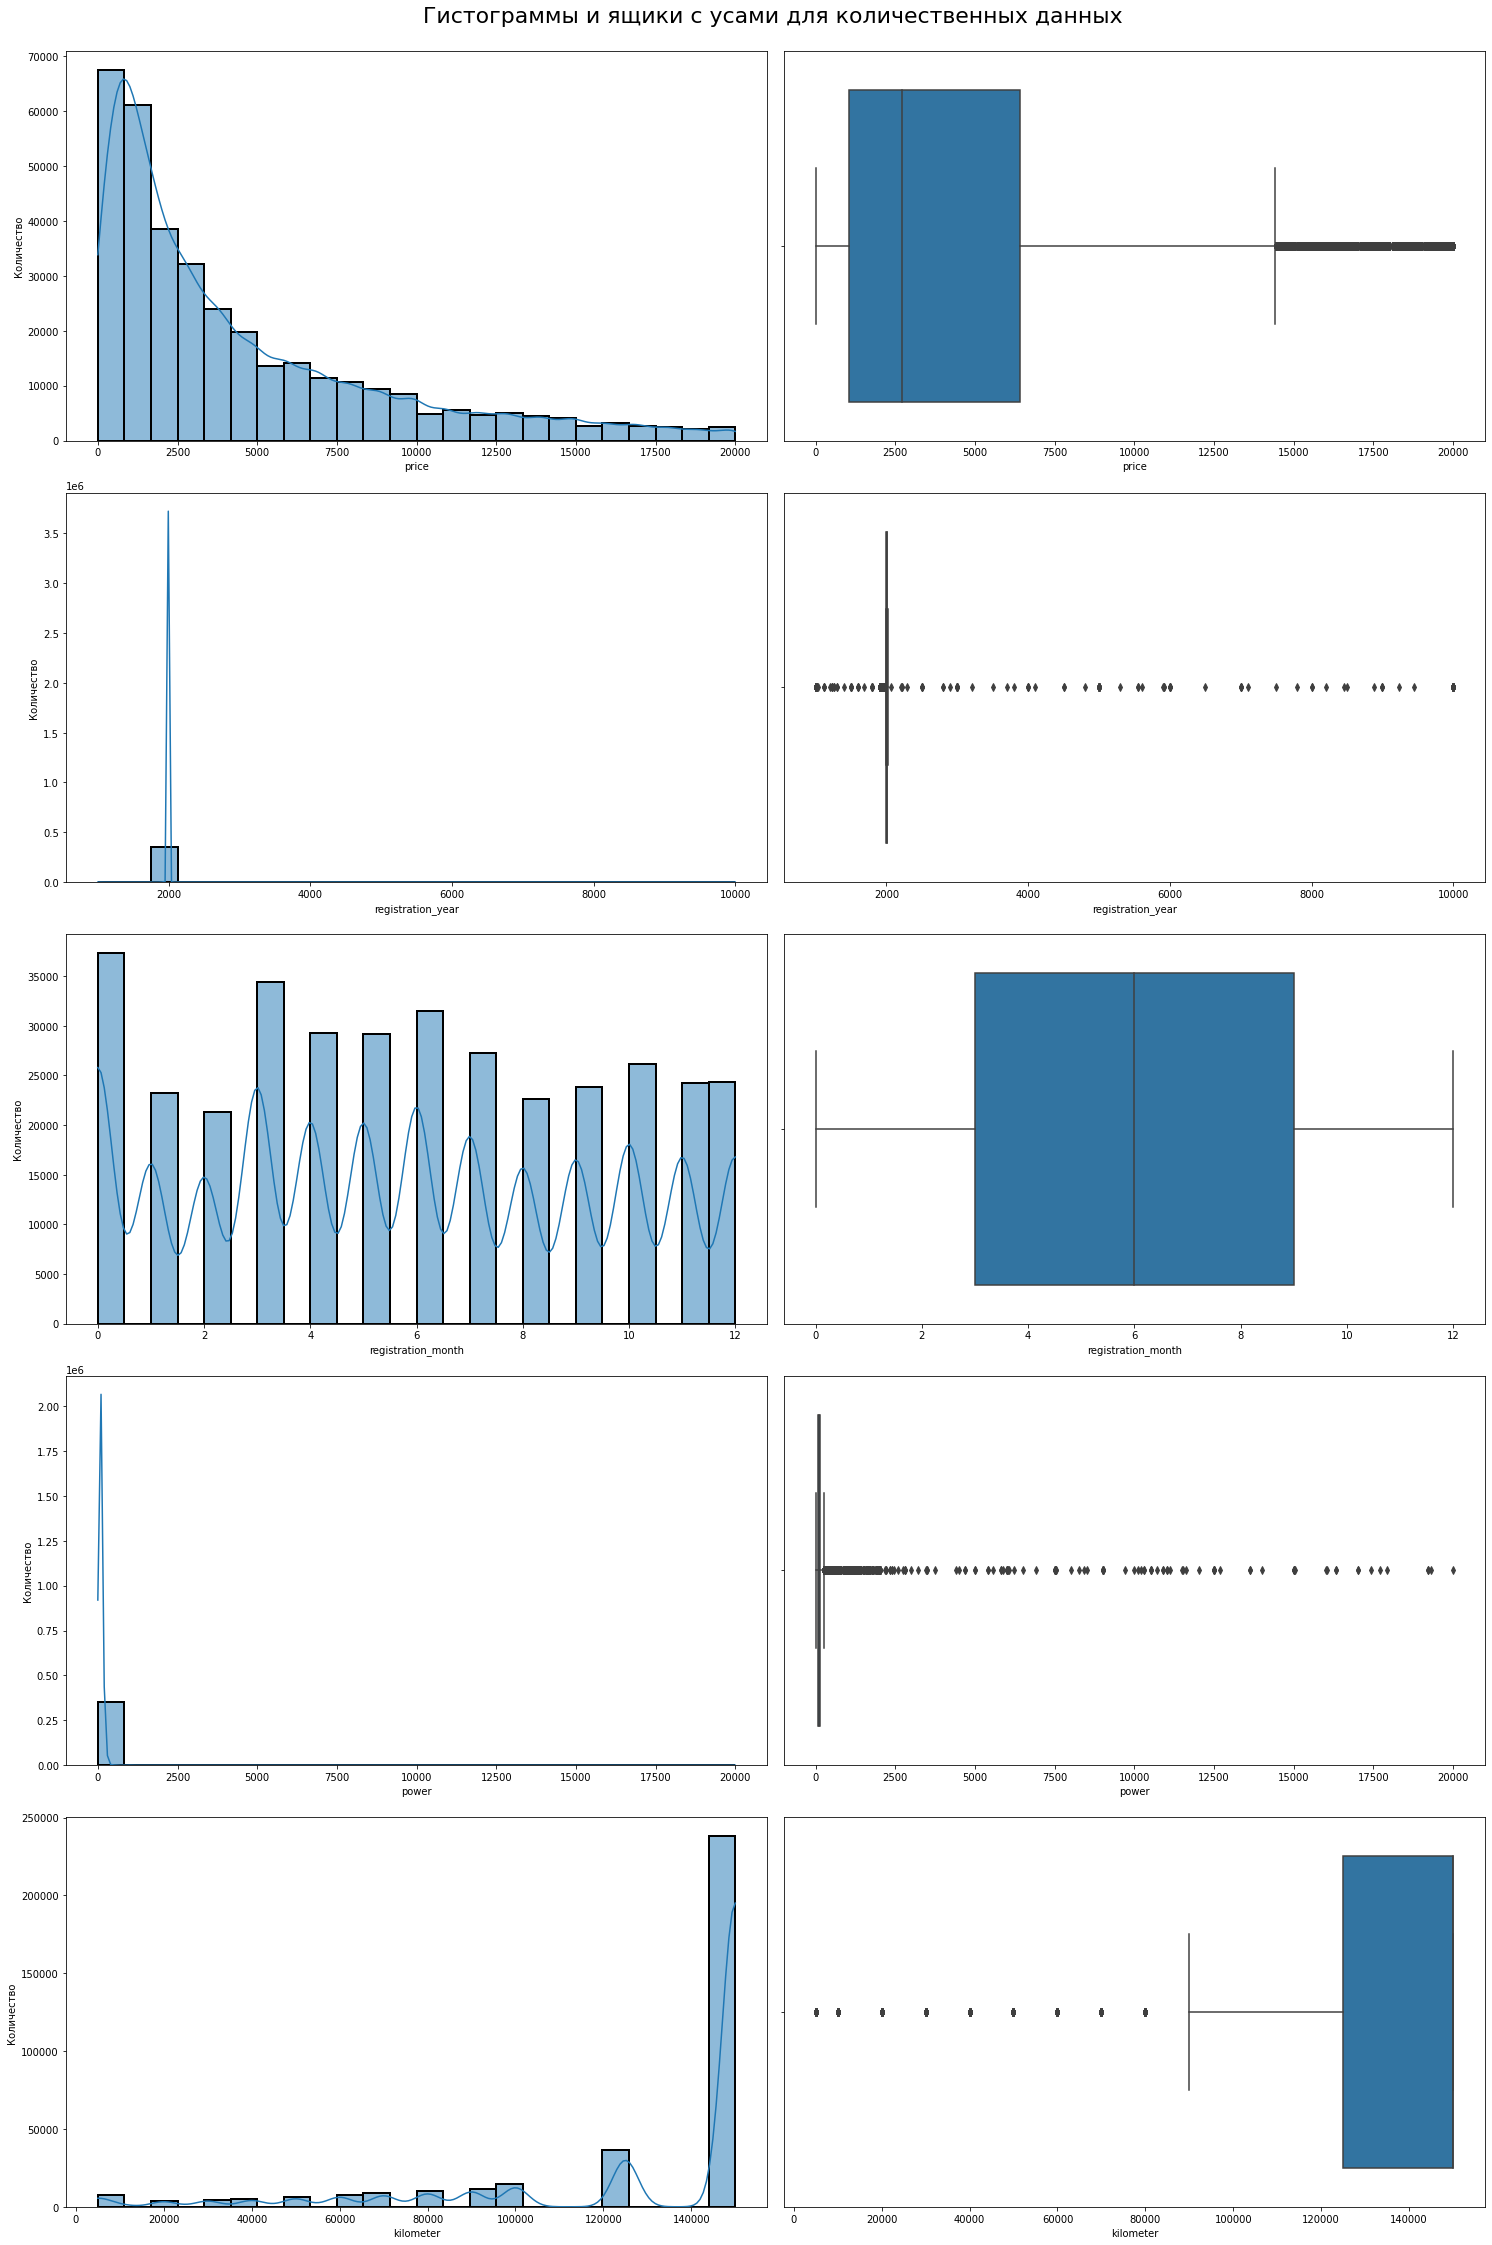

In [13]:
plot_hist(num_features, num_features.columns)

**Посмотрим на рапсределение значений некоторых переменных поближе**

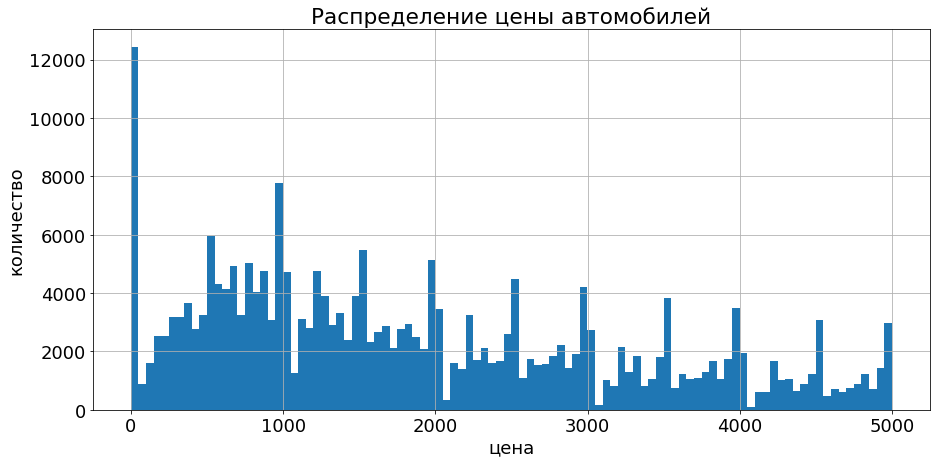

In [14]:
num_features['price'][num_features['price'] < 5000].hist(bins = 100, figsize = (15,7))
plt.xlabel('цена')
plt.ylabel('количество')
plt.title('Распределение цены автомобилей')
plt.show()

In [15]:
fig, ax = plt.subplots()
sns.countplot(y='registration_year', data=num_features, palette='coolwarm')
ax.set_title('Распределение по году регистрации авто', fontsize = 100)
plt.ylabel('Количество')
plt.bar_label(ax.containers[0], fmt='%.0f', padding=1, color = 'red', rotation=0, fontsize = 50)
plt.xticks(fontsize = 50, rotation=90)
plt.yticks(fontsize = 60)
fig.set_figheight(200)
fig.set_figwidth(100)

plt.show()

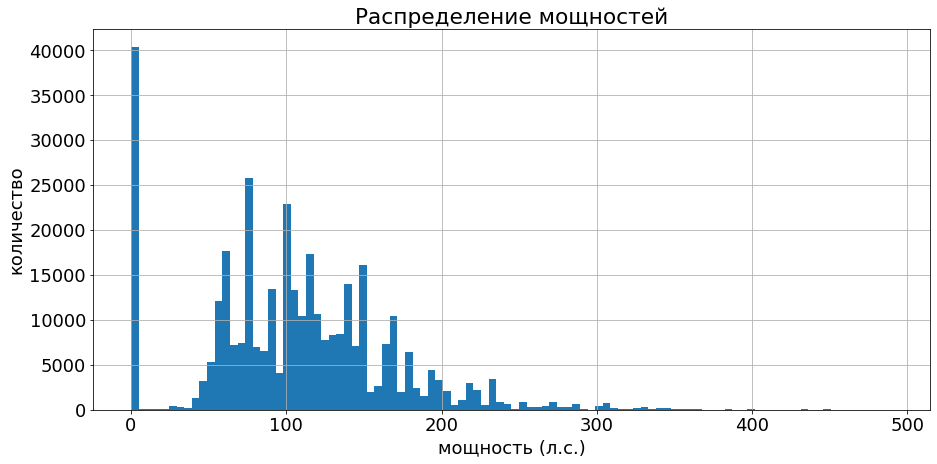

In [16]:
num_features['power'][num_features['power'] < 500].hist(bins = 100, figsize = (15,7))
plt.xlabel('мощность (л.с.)')
plt.ylabel('количество')
plt.title('Распределение мощностей')
plt.show()

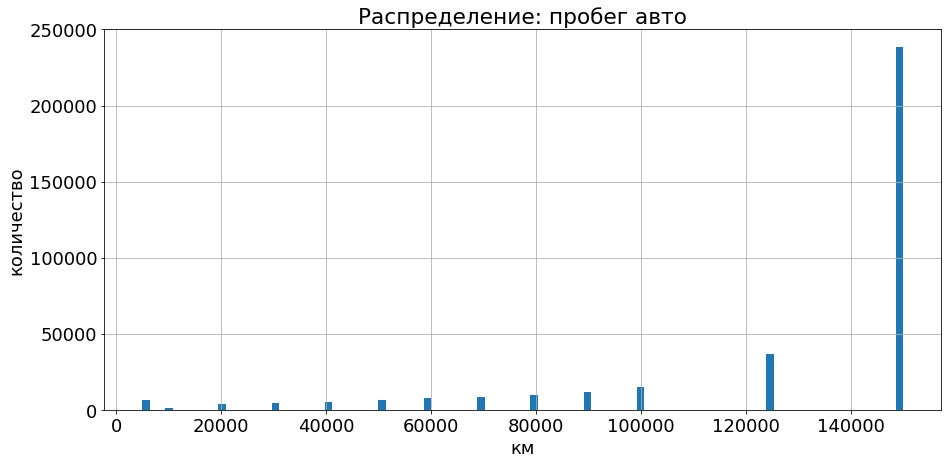

In [17]:
num_features['kilometer'].hist(bins = 100, figsize = (15,7))
plt.xlabel('км')
plt.ylabel('количество')
plt.title('Распределение: пробег авто')
plt.show()

In [18]:
num_features.describe().T.style.format("{:,.2f}")

,count,mean,std,min,25%,50%,75%,max
price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
registration_year,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
registration_month,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"


In [19]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x)
#calculate CV
cv(num_features)

price                 1.022076
registration_year     0.045019
registration_month    0.652083
power                 1.724434
kilometer             0.295648
dtype: float64

**Столбец `price`**:
- имеет значительную правостороннюю асимметрию: Хср. > Me, следовательно распределение имеют тенденцию к увеличению соответствующих показателей (прогрессивности);
- аномально малые околонулевые значения - явные выбросы: "0" - является глобально модой в распределении;  
- набольшая часть данных расположены в ценовом диапазоне до 5000 евро, мода - около 1000 евро (не считая 0);
- наиболее репрезентативная часть данных - от 1050 до 6400 евро;
- **наиболее типичная цена (медиана) - 2 700 евро**;
- очень значительная степень рассеивания в данных;
- очень неоднородная совокупность

**Столбец `registration_year`**:
- имеет вполне симметричное распределение, группирующееся относитеьно 2003-2004 гг.;
- наблюдается локальные модальные значения ок 2015-2016
- **пристуствуют аномальные значения в интервалах: [1000;1909], [2017:]**;
- заметная степень рассеивания в данных;
- неоднородная совокупность (не в последнюю очередь - благодаря выбросам)

**Столбец `registration_month`**:
- имеется аномальное значение - "0", скорее всего, это вариация в обозначении января;

**Столбец `power`**:
- имеет значительную правостороннюю асимметрию: Хср. > Me, следовательно распределение имеют тенденцию к увеличению соответствующих показателей (прогрессивности);
- наиболее репрезентативная часть данных - от 69 до 143 л.с.;
- содержит явно аномальные значения:
    - 0 л.с.: скорее всего, эти значения соответствуют пропускам при заполнении пользователями анкет;
    - x > 2000 л.с.: насколько знаю, до сих пор, в 2023, не существует легковых автомобилей, оборудованных двигателями (моторами) свыше 2000 л.с.
- очень значительная степень рассеивания в данных;
- очень неоднородная совокупность

**Столбец `kilometer`**:
- имеет левостороннюю асимметрию: Хср. < Me, следовательно распределение имеют тенденцию к уменьшению соответствующих показателей (регрессивности);
- 75% данных расположены в диапазоне пробега от 125 тыс. до 150 тыс. км;
- наиболее репрезентативная часть данных - от 1050 до 6400 евро;
- **наиболее типичная цена (медиана) - 2 700 евро**;
- значительная степень рассеивания в данных;
- довольно однородная совокупность.

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4"><b>Визуализация</b></font>

Напишем собственную функцию для отображения качественных переменных на столбчатых диаграммах

In [20]:
# исключим из датафрейма с кат. переменными столбец с моделями автомобилей (слишком много уникальных номинальных значений)
categorial_feature_for_plot = data[['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']]

In [21]:
def categorial_feature_distribution(column):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.xticks(rotation=90)
    sns.countplot(x=column, data=cat_features, palette='coolwarm')
    ax.set_title('Распределение по ' + column,  fontsize = 20)
    plt.ylabel('Количество')
    plt.bar_label(ax.containers[0], fmt='%.0f', padding=1, color = 'red', rotation=45, fontsize = 8)
    plt.show()

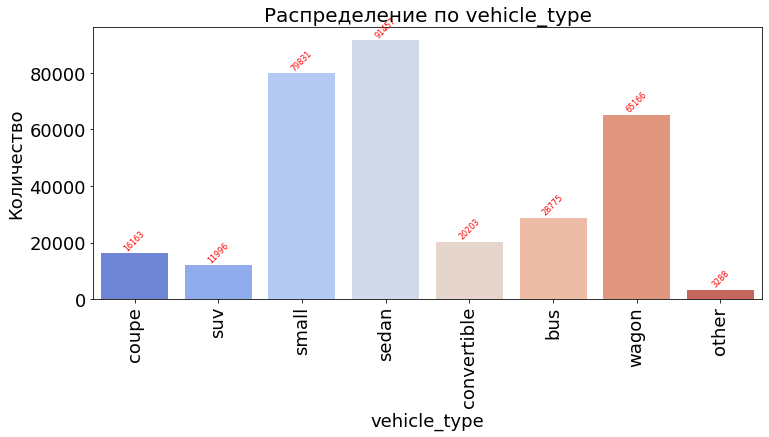

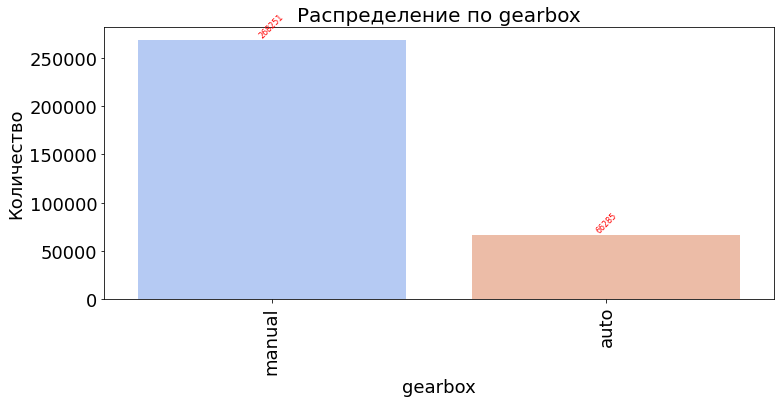

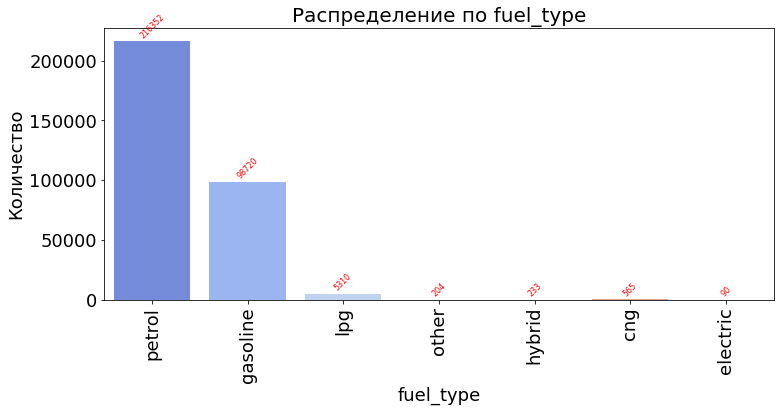

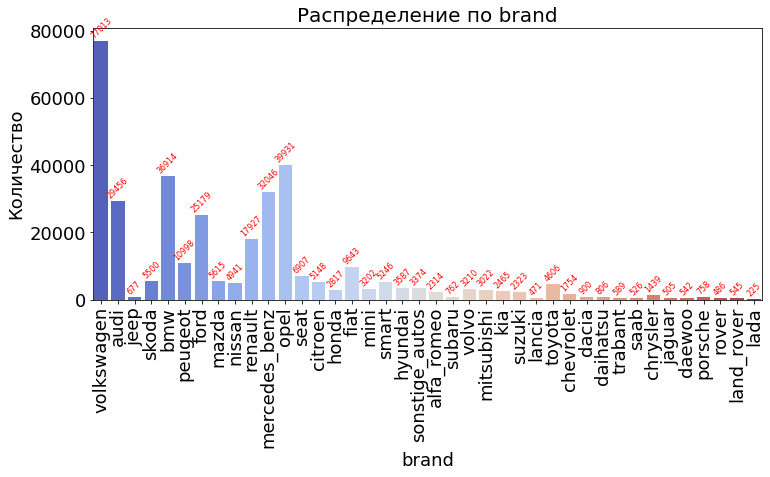

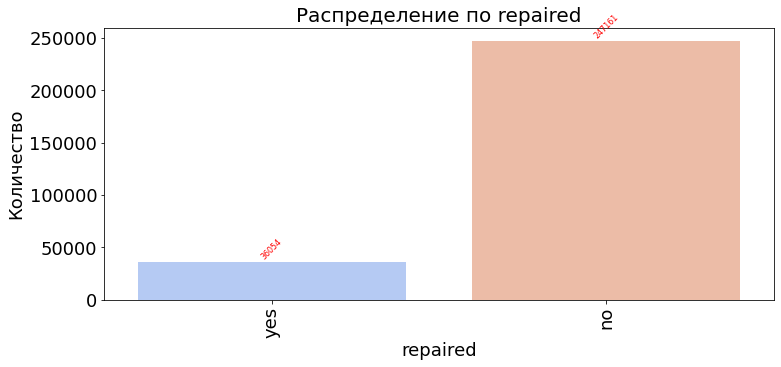

[None, None, None, None, None]

In [22]:
[categorial_feature_distribution(item) for item in categorial_feature_for_plot]

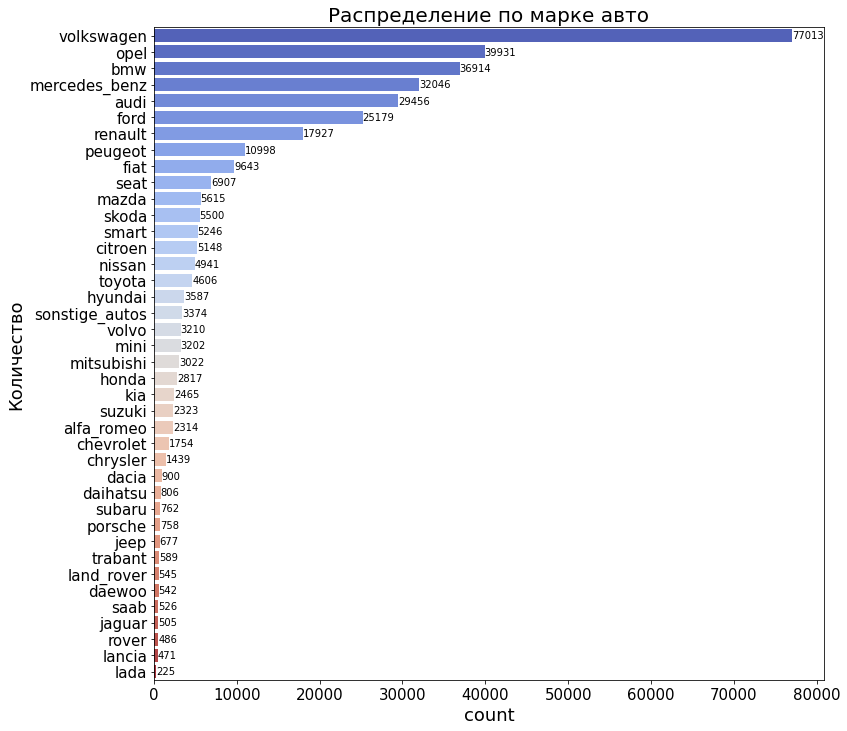

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.countplot(y='brand', data=cat_features, palette='coolwarm', order = cat_features['brand'].value_counts().index)
ax.set_title('Распределение по марке авто', fontsize = 20)
plt.ylabel('Количество')
plt.bar_label(ax.containers[0], fmt='%.0f', padding=0, color = 'black', rotation=0, fontsize = 10)
plt.xticks(fontsize = 15, rotation=0)
plt.yticks(fontsize = 15)
plt.show()

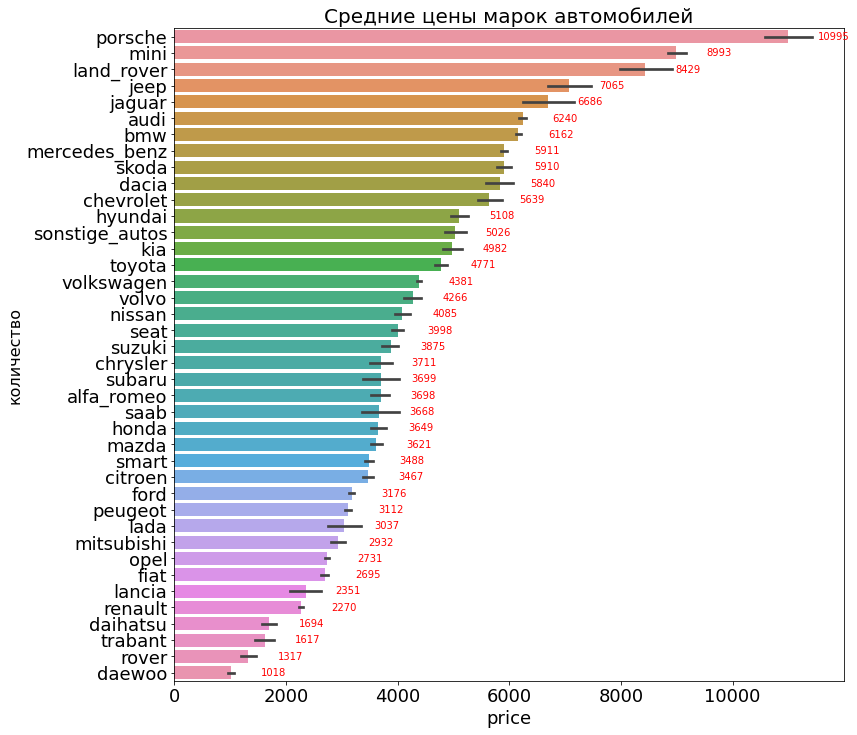

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(y='brand', x='price', data=data,
           order=data.groupby('brand')['price'].agg('mean').sort_values(ascending=False).index)
plt.bar_label(ax.containers[0], fmt='%.0f', padding=30, color = 'red', rotation=0, fontsize=10)
plt.title('Средние цены марок автомобилей', fontsize=20)
plt.ylabel('количество', fontsize=16)
plt.show()

`vehicle_type`:
- ожидаемо большинство авто - седаны;
- 3288 авто относятся к общей категории `other

`gearbox`:
- только ок. 19% автомобилей оборудованы АКПП

`fuel_type`**:
- ожидаемо большинство авто на бензине, чуть более 100 тысяч авто оборудованы двигателями, работающими на газ. топливе (+ lpg, cng);

`brand`:
- видим, что датасет составляют, в основном, марки автомобили, наиболее популярные модели которых относят к эконом-классу;
- при этом модельный ряд наиболее популярных марок представлен очень вариабельно, моделями разных ценовых диапазонов: так, средняя цена автомобилей марки volkswagen > средней цены volvo; hyundai впереди всех японских брендов и т.д.
- цена по условию в евро, следовательно рынок, скорее всего европейский: не удивительно, что большая часть марок авто также европейская;
- тройка лидеров - "немцы": volkswagen, opel, bmw, mercedez_benz, audi; за ними американский ford, далее - французы (renault, peugeot); интересно, что самый популярный японец - mazda;

`repaired`:
- подавляющее большинство автомобилей - без ремонта.

### Устранение полных дубликатов

In [25]:
data = data.drop_duplicates()

In [26]:
data.shape[0] # удалили 4 явных дубликата

354365

### Изменение типов данных, устранение явных аномалий

#### Изменение типов данных

In [27]:
data['date_crawled'] = pd.to_datetime(data['date_crawled']) # преобразуе данные в спец формат
data['date_created'] = pd.to_datetime(data['date_created']) # преобразуе данные в спец формат
data['last_seen'] = pd.to_datetime(data['last_seen']) # преобразуе данные в спец формат

In [28]:
data['date_crawled'].min(), data['date_crawled'].max() # выведем размах данных в столбце

(Timestamp('2016-03-05 14:06:22'), Timestamp('2016-04-07 14:36:58'))

In [29]:
data['date_crawled'].max() - data['date_crawled'].min()

Timedelta('33 days 00:30:36')

Видим, что данные скачивались из БД в течение 33 дней, с 05 марта 2016 по 07 апреля 2016

In [30]:
data['date_created'].min(), data['date_created'].max() # выведем размах данных в столбце

(Timestamp('2014-03-10 00:00:00'), Timestamp('2016-04-07 00:00:00'))

In [31]:
data['date_created'].max() - data['date_created'].min()

Timedelta('759 days 00:00:00')

Видим, что период наблюдения составляет 759 дней: пользователи размещали анкеты с 10 марта 2014 по 07 апреля 2016

In [32]:
data['last_seen'].min(), data['last_seen'].max() # выведем размах данных в столбце

(Timestamp('2016-03-05 14:15:08'), Timestamp('2016-04-07 14:58:51'))

In [33]:
data['last_seen'].max() - data['last_seen'].min()

Timedelta('33 days 00:43:43')

Видим, что период последних активностей пользователей совпадает с периодом скачивания анкет из БД

#### Выявление и устранение явных аномалий

In [34]:
data[data['date_crawled'] < data['date_created']].shape[0]

0

То есть отсуствуют более поздние даты создания анкет по сравнению с датами их скачивания: аномалии здесь не обнаружены 

**В целях сравнения значений в столбцах `registration_year` and `registration_month` соответственно с годом и месяцем создания объявлений создадим столбцы `year_created` and `month_created`**

In [35]:
data['year_created'] = data['date_created'].apply(lambda x: x.year)
data['year_created'].head()

0    2016
1    2016
2    2016
3    2016
4    2016
Name: year_created, dtype: int64

In [36]:
data['month_created'] = data['date_created'].apply(lambda x: x.month)
data['month_created'].head()

0    3
1    3
2    3
3    3
4    3
Name: month_created, dtype: int64

In [37]:
data.query('registration_year > year_created').shape[0]

14530

**Очевидно, соответствующие объекты являются аномальными, удалим их из датафрейма**

In [38]:
data = data.query('registration_year <= year_created').reset_index(drop=True)
data.shape[0] # check

339835

Теперь посмотрим, имеются ли в датафрейме **объекты с одним и тем же годом регистрации авто и создания анкеты, но более поздним месяцем регистрации авто (по сравнению с месяцем создания анкеты)**. 

In [39]:
data.query('(registration_month > month_created) and (registration_year == year_created)').shape[0]

5230

Таковые имеются, удалим соответствующие строки

In [40]:
data = data.query('not((registration_month > month_created) and (registration_year == year_created))').reset_index(drop=True)
data.shape[0] # check

334605

При первичном анализе данных выявили, что в `registration_year` **пристуствуют явно аномальные значения в интервалах: [1000;1910], [2017:]. Также удалим их**.

In [41]:
data = data.query('(registration_year > 1910) and (registration_year < 2017)').reset_index(drop=True)
data.shape[0] # check

334438

Выше выявили, что в столбце `registration_month` имеется аномальное значение - "0", скорее всего, это вариация в обозначении января, то есть 1го месяца: **заменим нулевые значения на "1"**

In [42]:
data.loc[data['registration_month'] == 0, 'registration_month'] = 1

<Axes: >

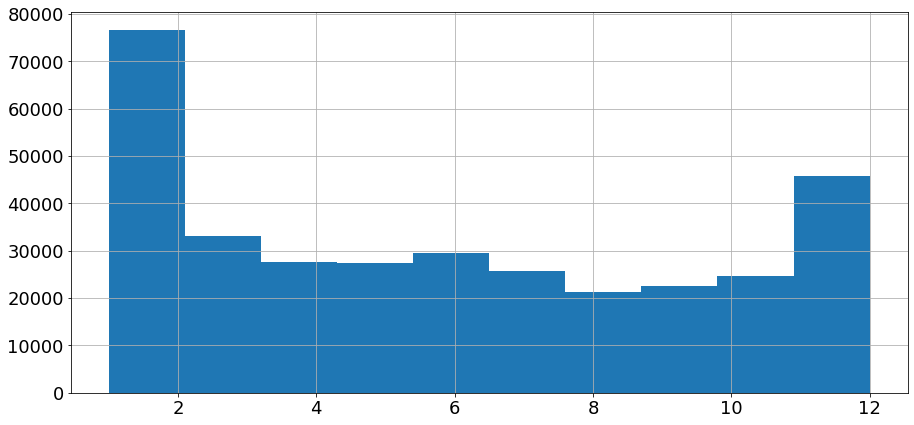

In [43]:
data['registration_month'].hist(figsize = (15, 7))

**Целевой столбец `price` содержит аномальные нулевые значения - явные выбросы**; при этом "0" является глобально модой в распределении. Полагаю, что, скорее всего, это пропуски, заполненные "0", однако восстанавливать значения целевого признака по другим данным, заполняя его синтетическими данным было бы некорректным. Удалим соответствующие объекты.

In [44]:
data = data.loc[data['price'] != 0].reset_index(drop=True)
data.shape[0]

324737

**Столбец `power` также содержит аномальные значения**:
    - 0 л.с.: скорее всего, эти значения соответствуют пропускам при заполнении пользователями анкет;
    - x > 2000 л.с.: насколько знаю, до сих пор, в 2023, не существует легковых автомобилей, оборудованных двигателями (моторами) свыше 2000 л.с.

---
Исходя из гипотезы о том, что 0-е значения являются пропусками, заполним их в дальнейшем медианными значениями переменной, сгруппированными по моделям или маркам автомобилей.

---
**В качестве верхней границы обозначим 2000 л.с.**

In [45]:
data = data.query('power<=2000').reset_index(drop=True)
data.shape[0] # check

324638

**Посмотрим на распределение в `price`в диапазоне заданных квантилей:**

In [46]:
data['price'].describe(percentiles=[.01,.03, .05, .1, .15, .25, .5, .75, .95, .97,.99])

count    324638.000000
mean       4641.017071
std        4558.093255
min           1.000000
1%          100.000000
3%          250.000000
5%          350.000000
10%         599.000000
15%         799.000000
25%        1200.000000
50%        2950.000000
75%        6700.000000
95%       14900.000000
97%       16500.000000
99%       18900.000000
max       20000.000000
Name: price, dtype: float64

Более или менее адекватными выглядят значения по 1му и 99му процентилям.

In [47]:
data = data[(data.price >= data.price.quantile(.01)) & (data.price <= data.price.quantile(.99))].reset_index(drop=True)
data.shape[0]

319308

### Обработка пропусков

In [48]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          13934
registration_year         0
gearbox               14084
power                     0
model                 14416
kilometer                 0
registration_month        0
fuel_type             21040
brand                     0
repaired              56158
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
year_created              0
month_created             0
dtype: int64

видим, что после удаления явно аномальных значений уменьшилось и количество пропусков в столбцах

**Визуализируем количество пропусков в столбцах с помощью собственной функции**:

In [49]:
def pass_value_barh(df):
    try:
        ax = \
        (
            (df.isna().mean()*100)
            .to_frame().rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
        )
        ax = ax.plot(kind = 'barh', figsize = (19,10), rot = 0, legend = True, fontsize = 16) 
        plt.title('Количество пропусков в столбцах (%)' + "\n", fontsize = 22, color = 'Black')
        plt.bar_label(ax.containers[0], fmt='%.2f%%', padding=0, color = 'red')
        plt.xlabel('проценты', fontsize=16)
        plt.xticks(np.arange(0, 20, step=1))

    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

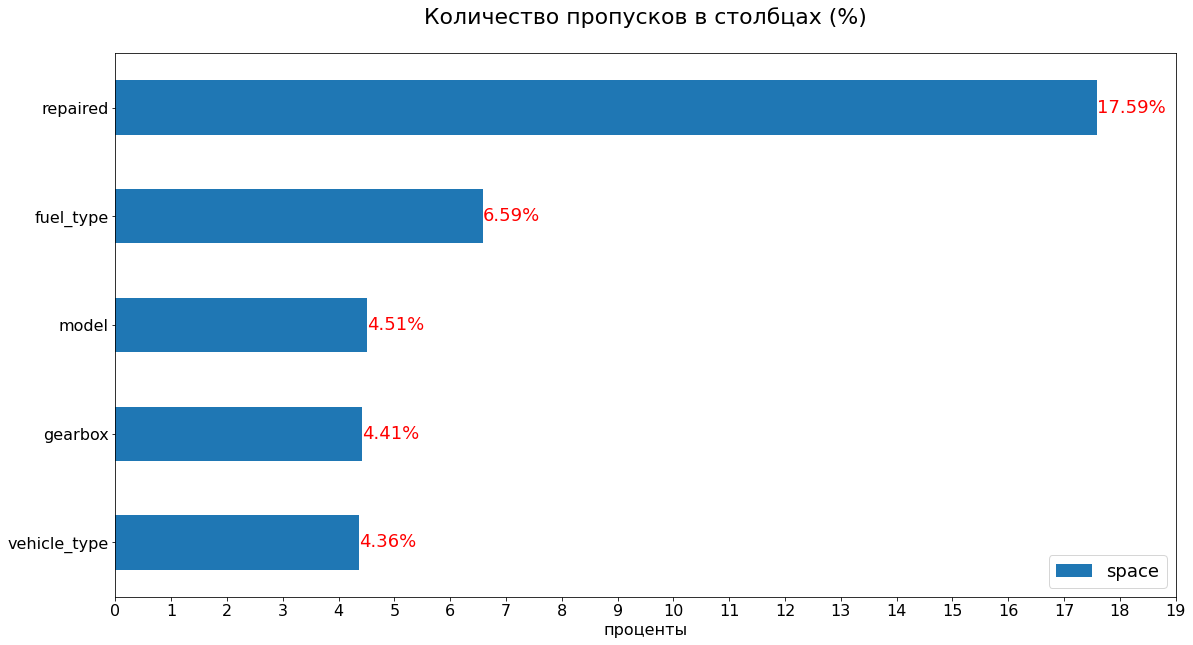

In [50]:
pass_value_barh(data)

**Устранение пропусков в `repaired`**

Кажется вполне вероятным, что пропуски в этом столбце связаны с отсутствием соответствующей информации о том, была ли машина в ремонте. Исходя из этого, логично заполнить их 'no'.

In [51]:
data["repaired"] = data["repaired"].fillna("no")
data["repaired"].isna().sum() # check

0

**Устранение пропусков в `model`**

Пропуски в данном столбце не представляется возможным корректно восстановить из значений других признаков. Целесообразно заменить их на значение 'unknown'. Данную переменную будем использовать при заполнении пропущенных значений в других столбцах, группируя их по `model`

In [52]:
data['model'] = data['model'].fillna('unknown')
data["model"].isna().sum() # check

0

**Устранение пропусков в `fuel_type`**

Пропуски в данном столбце:
- если они совпадают с соотв. значением 'unknown' в `model`, заполним также - 'unknown';
- остальные - модой в сгруппированных данных относительно модели

In [53]:
data[(data['model']=='unknown') & (data['fuel_type'].isna())].shape[0] # check

4233

In [54]:
data.loc[
    (
        (data['model']=='unknown') & (data['fuel_type'].isna())
    ),
    'fuel_type'
] = data['fuel_type'].fillna(data.groupby('brand')['fuel_type'].transform(lambda x: x.value_counts().idxmax()))

In [55]:
data['fuel_type'] = data['fuel_type'].fillna(data
                                         .groupby('model')['fuel_type']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [56]:
data['fuel_type'].value_counts()

petrol      218030
gasoline     95369
lpg           4948
cng            520
hybrid         208
other          147
electric        86
Name: fuel_type, dtype: int64

In [57]:
data['fuel_type'].isna().sum()

0

**Устранение пропусков в `gearbox`**

Пропуски в данном столбце заполним аналоично

In [58]:
data[(data['model']=='unknown') & (data['gearbox'].isna())].shape[0] # check

2308

In [59]:
data.loc[
    (
        (data['model']=='unknown') & (data['gearbox'].isna())
    ),
    'gearbox'
] = data['gearbox'].fillna(data.groupby('brand')['gearbox'].transform(lambda x: x.value_counts().idxmax()))

In [60]:
data['gearbox'] = data['gearbox'].fillna(data
                                         .groupby('model')['gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [61]:
data['gearbox'].value_counts()

manual    257038
auto       62270
Name: gearbox, dtype: int64

In [62]:
data['gearbox'].isna().sum()

0

**Устранение пропусков в `vehicle_type`**

Пропуски в данном столбце заполним аналоично

In [63]:
data[(data['model']=='unknown') & (data['vehicle_type'].isna())].shape[0] # check

2768

In [64]:
data.loc[
    (
        (data['model']=='unknown') & (data['vehicle_type'].isna())
    ),
    'vehicle_type'
] = data['vehicle_type'].fillna(data.groupby('brand')['vehicle_type'].transform(lambda x: x.value_counts().idxmax()))

In [65]:
data['vehicle_type'] = data['vehicle_type'].fillna(data
                                         .groupby('model')['vehicle_type']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [66]:
data['vehicle_type'].value_counts()

sedan          95264
small          81398
wagon          64290
bus            28988
convertible    19506
coupe          15309
suv            11526
other           3027
Name: vehicle_type, dtype: int64

In [67]:
data['vehicle_type'].isna().sum()

0

**Устранение '0' в `power`**

Заменим 0-е значения на NaN, далее - действуем аналогично, с предварительной группировкой по марке автомобиля

In [68]:
data.loc[data['power'] == 0].shape[0]

30304

In [69]:
data.loc[data['power'] == 0,'power'] = np.nan
data['power'].isna().sum() # check

30304

In [70]:
# data.loc[((data['model']=='unknown') & (data['power'].isna())), 'power'] = 'unknown'

In [71]:
data['power'] = data['power'].fillna(data.groupby('brand')['power'].transform(lambda x: x.value_counts().idxmax()))

In [72]:
data['power'].isna().sum() # check

0

**Теперь, в заключение, удалим объекты с мощностью менее 40 л.с., явно аномальные значения, которые адекватно не представляется возможным восстановить из имеющихся данных**

In [73]:
data = data.query('power > 40').reset_index(drop=True)
data.shape[0] # check

316879

In [74]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
year_created          0
month_created         0
dtype: int64

**Посмотрим, как изменились распределения и статистики признаков после предобработки**

In [75]:
# датафрейм: категориальные признаки 
cat_features = data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'kilometer']]
# датафрейм: количественные признаки (хотя год и месяц - дискретные данные, которые от-ся к кат. переменным, для целей виз-ии
# можно "приписать" их к количественным)  
num_features = data[['price', 'registration_year', 'registration_month', 'power', 'kilometer']]

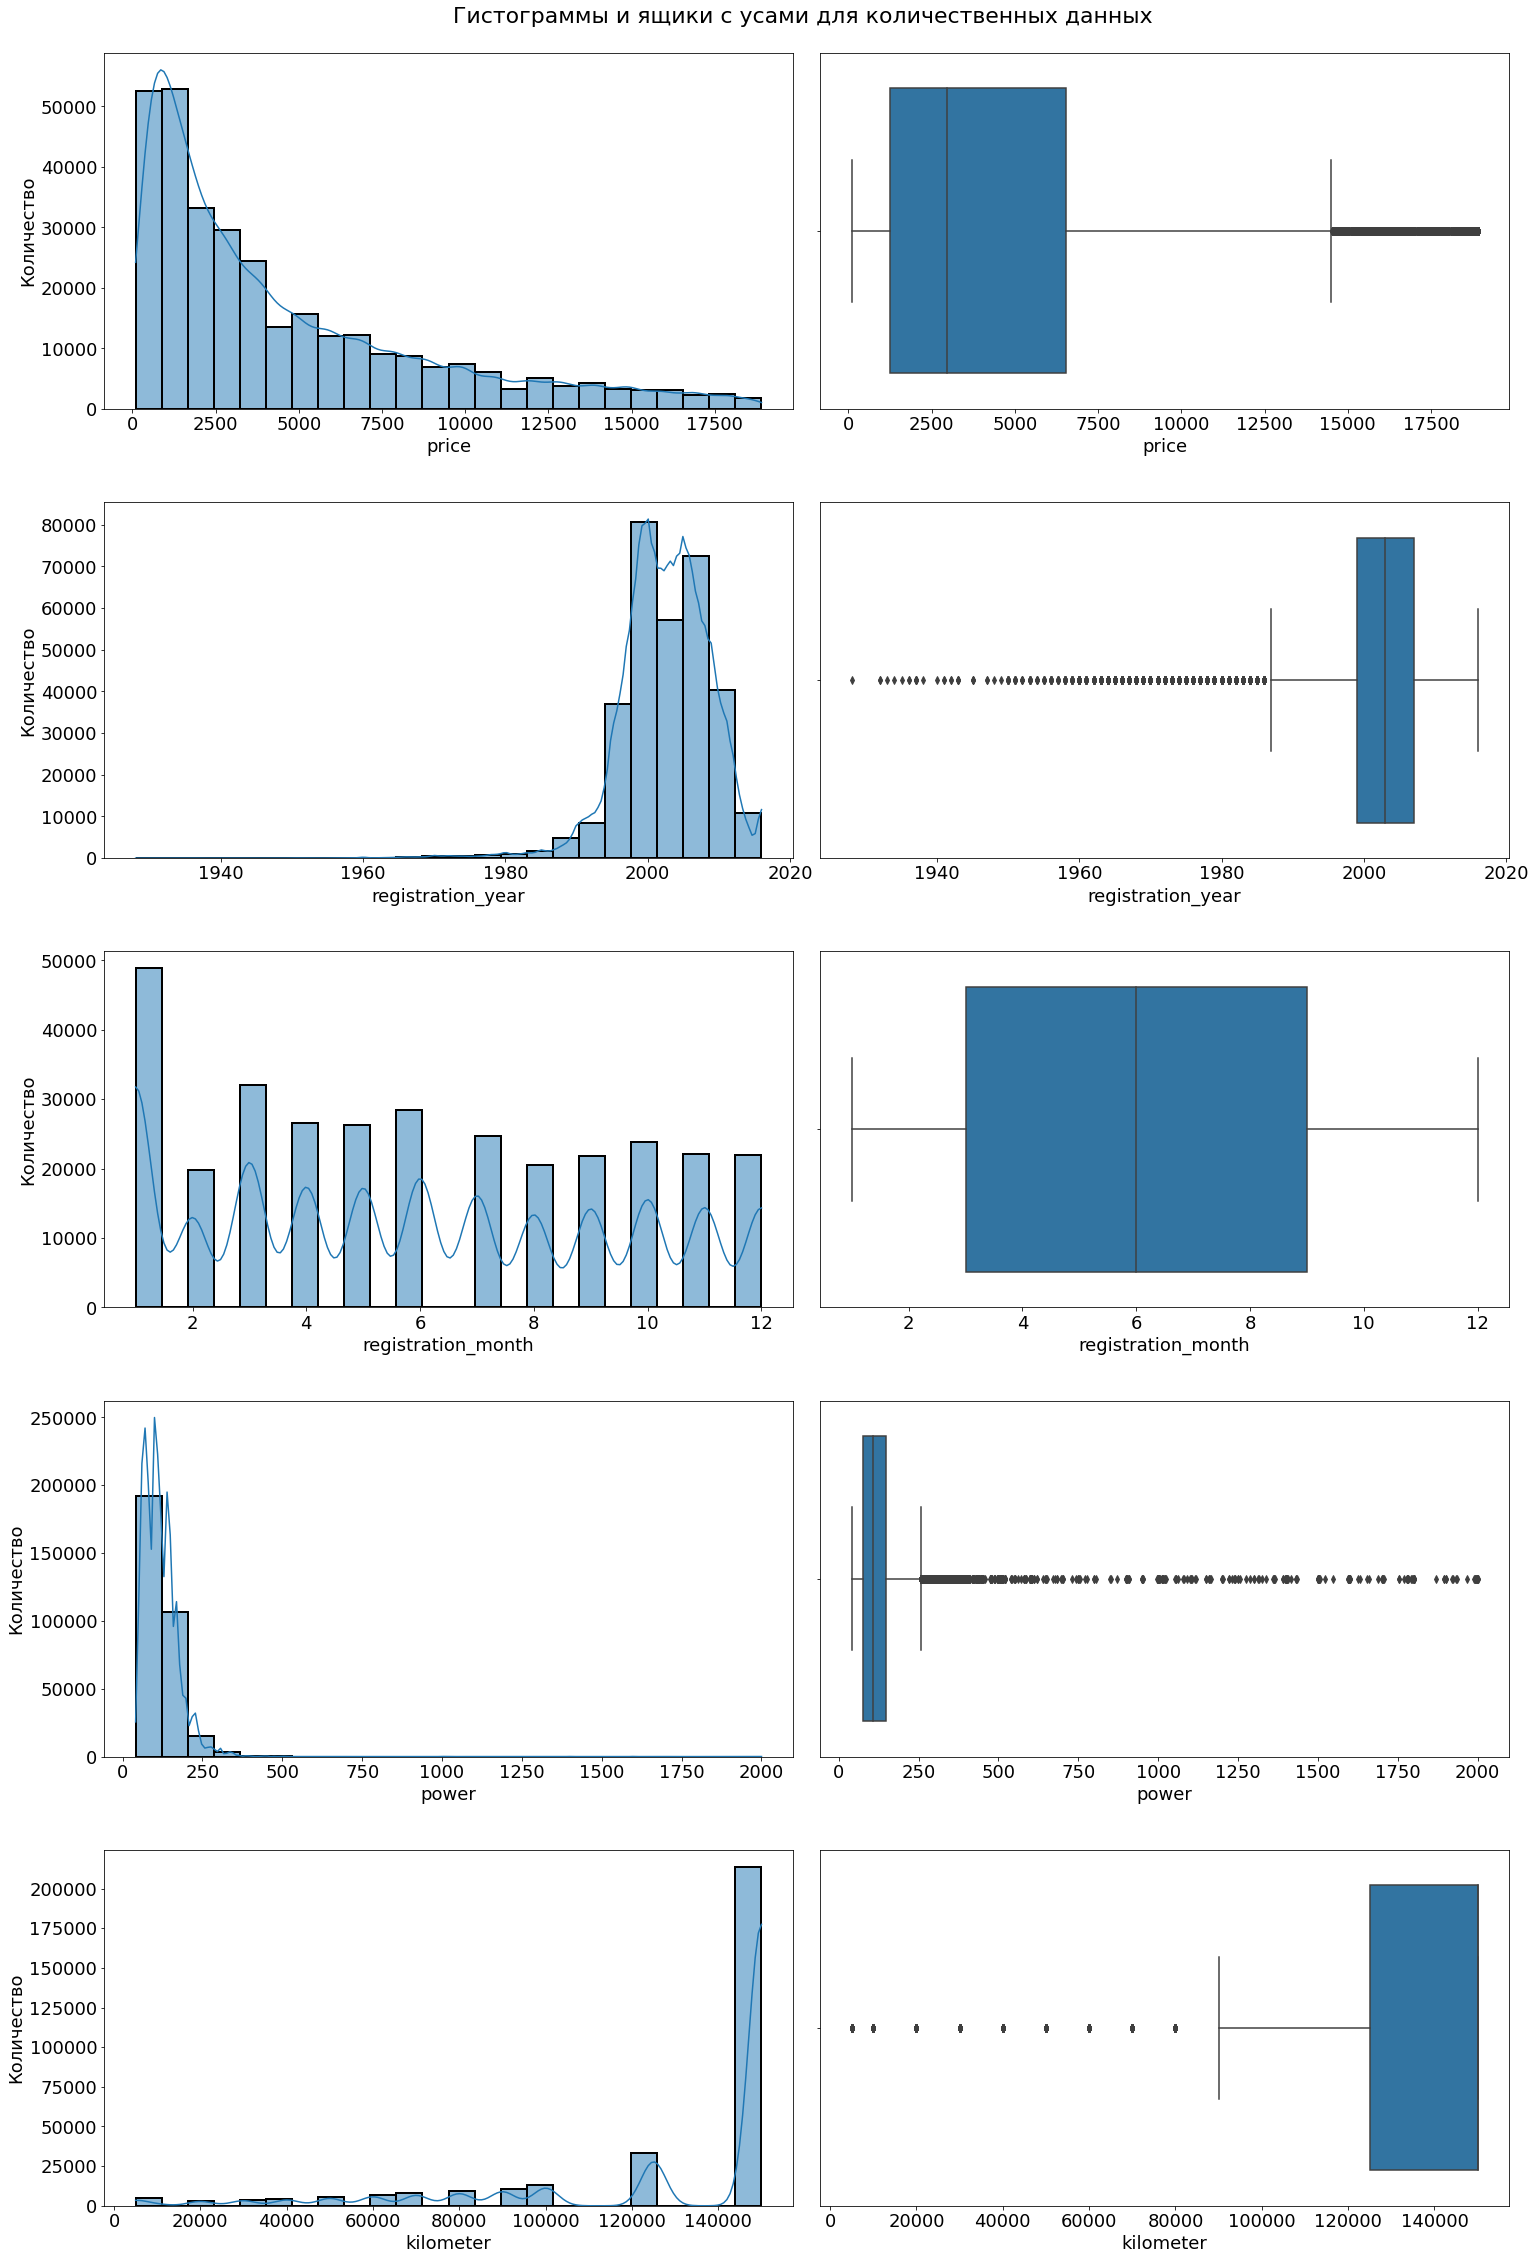

In [76]:
plot_hist(num_features, num_features.columns)

In [77]:
categorial_feature_for_plot = data[['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'kilometer']]

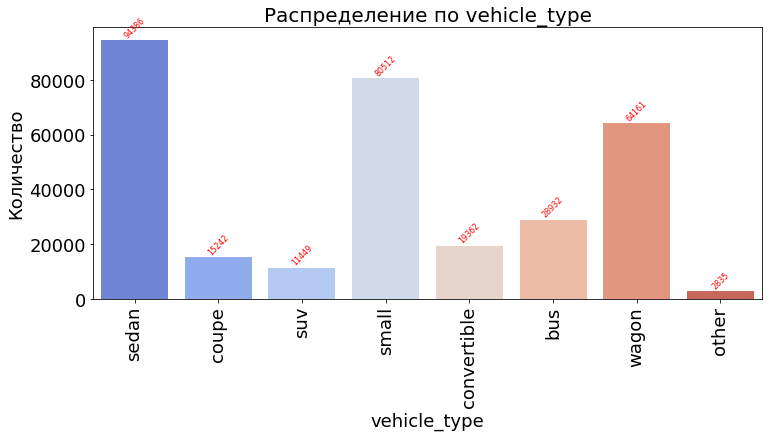

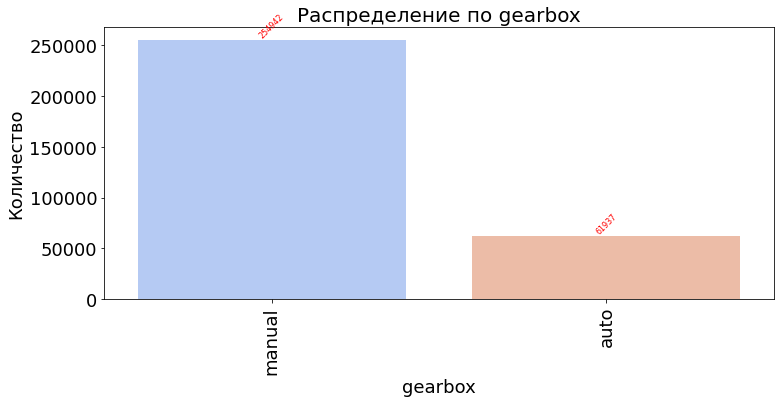

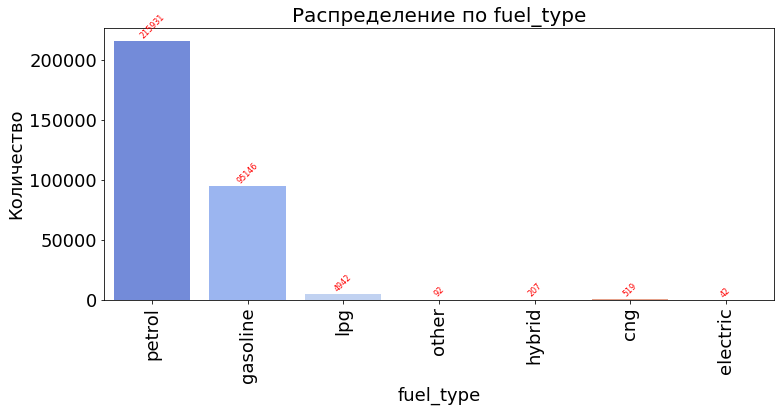

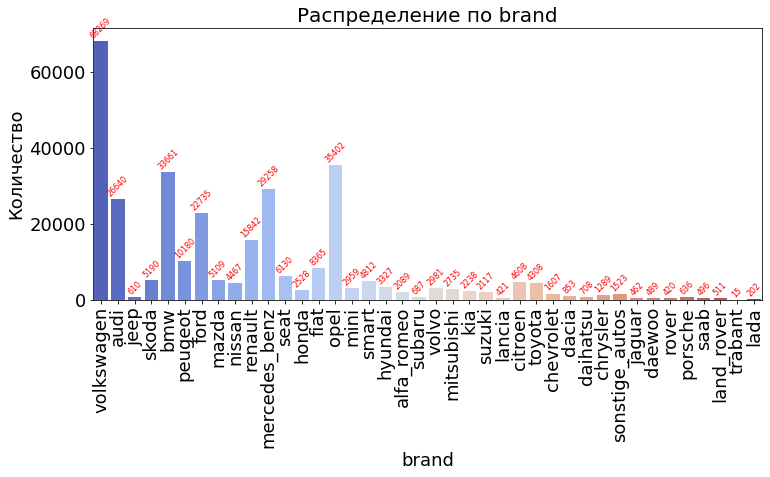

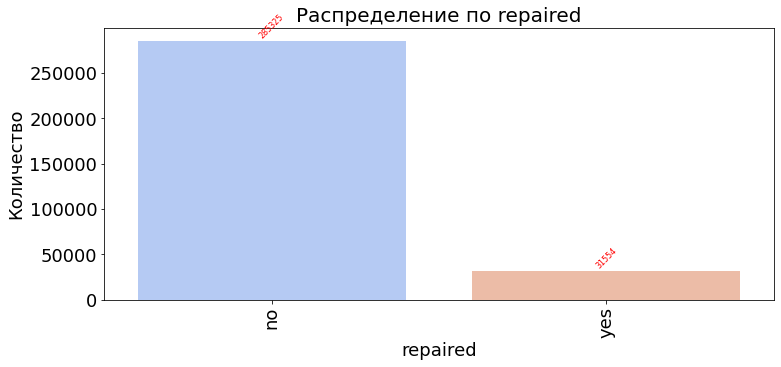

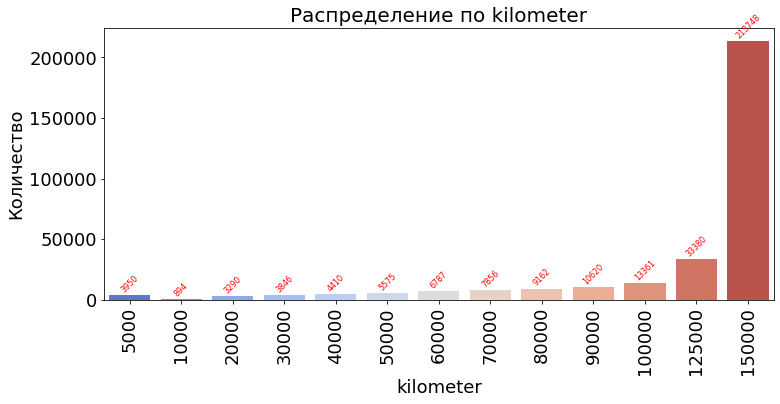

[None, None, None, None, None, None]

In [78]:
[categorial_feature_distribution(item) for item in categorial_feature_for_plot]

In [79]:
data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date_crawled,316879,249645,2016-03-24 14:49:47,6,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,316879.0,NaN,NaN,NaN,NaT,NaT,4546.550071,4347.894079,100.0,1250.0,2950.0,6550.0,18900.0
vehicle_type,316879,8,sedan,94386,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,316879.0,NaN,NaN,NaN,NaT,NaT,2002.47905,6.361844,1928.0,1999.0,2003.0,2007.0,2016.0
gearbox,316879,2,manual,254942,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,316879.0,NaN,NaN,NaN,NaT,NaT,119.419147,61.025894,41.0,75.0,109.0,148.0,2000.0
model,316879,251,golf,25828,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,316879.0,NaN,NaN,NaN,NaT,NaT,129013.661366,36568.535341,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,316879.0,NaN,NaN,NaN,NaT,NaT,5.903758,3.545788,1.0,3.0,6.0,9.0,12.0
fuel_type,316879,7,petrol,215931,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x)
#calculate CV
cv(num_features)

price                 0.956306
registration_year     0.003177
registration_month    0.600598
power                 0.511023
kilometer             0.283447
dtype: float64

**Столбец `price`**:
- после предобработки данных совокупность стала более однородной засчет уменьшения std, однако степень рассеяния, в любом случае, остается значительной;
- после предобработки данных Me и Хср почти не изменились

**Столбец `registration_year`**:
- после избавления от аномальных "хвостов" совокупность стала более сбалансированной;
- ярко выражена бимодальность: в конце 90х гг. - начале 00-х и в конце 00-х соответственно;
- после предобработки данных Me и Хср почти не изменились


**Столбец `power`**:
- после предобработки данных кратно снизилась степень рассеивания данных, существенно уменьшилось std
- после предобработки данных Me и Хср почти не изменились

**Столбцы c категориальными признаками не претерпели существенных изменений**

### Удаление неинформативных признаков

Удалим:

- столбцы с датами;
- столбец с фотографиями, поскольку в нем только нулевые значения;
- столбец с почтовым индексом

---
Все эти столбцы не являются информативными, исходя из поставленной задачи

In [81]:
data = data.drop(['date_crawled',
                  'date_created',
                  'number_of_pictures',
                  'postal_code',
                  'last_seen',
                  'year_created',
                  'month_created'], axis=1).reset_index(drop=True)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316879 entries, 0 to 316878
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               316879 non-null  int64  
 1   vehicle_type        316879 non-null  object 
 2   registration_year   316879 non-null  int64  
 3   gearbox             316879 non-null  object 
 4   power               316879 non-null  float64
 5   model               316879 non-null  object 
 6   kilometer           316879 non-null  int64  
 7   registration_month  316879 non-null  int64  
 8   fuel_type           316879 non-null  object 
 9   brand               316879 non-null  object 
 10  repaired            316879 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.6+ MB


### Корреляционный анализ

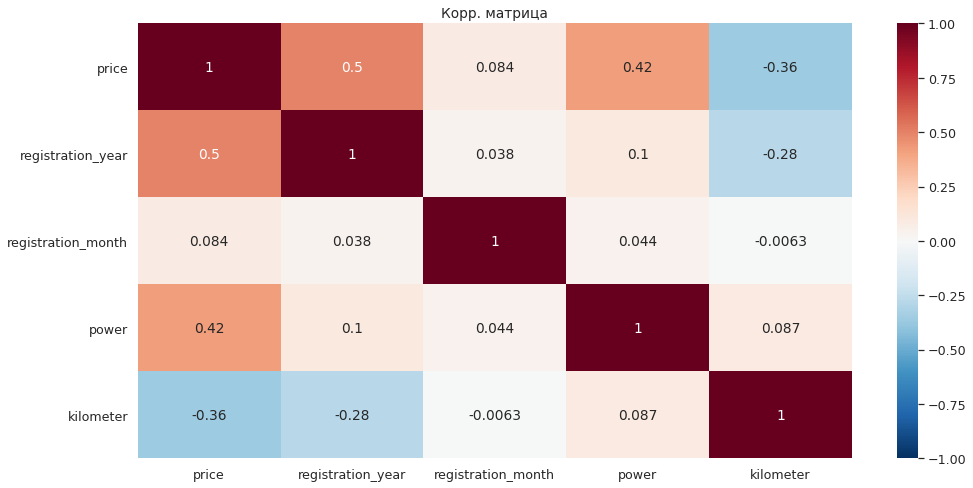

In [83]:
sns.set(font_scale=1.15)
plt.figure(figsize=(16,8))
plt.title('Корр. матрица')
sns.heatmap(num_features.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1)
plt.show()

Видим, что наиболее значительная (умеренная, переходящая в заметную) прямая линейная связь наблюдается между значениями переменной `registration_year` и целевой переменной; умеренной прямой также является связь с `power`; с `kilometer` цена связана обратной умеренной связью. В общем, год регистрации, мощность двигателя и пробег как-то слабо связаны с изменением цены автомобиля. Посмотрим, какова будет важность этих признаков при обучении моделей. 

### Разделение исходных данных на обучающую и тестовую выборки

In [84]:
RANDOM_SEED = 42 # предварительно создадим переменную со значением "42" для последующего случайного характера разделения данных

In [85]:
X = data.drop(['price'], axis=1) # сохраним в отдельной переменной признаки для обучения
y = data['price'] # сохраним в отдельной переменной целевой признак

print(X.shape)
print(y.shape)

(316879, 10)
(316879,)


In [86]:
(
    X_train, 
    X_test,
    y_train,
    y_test) = train_test_split(X,
                               y,
                               test_size=0.2,
                               random_state=RANDOM_SEED,
                               shuffle=True
                              ) # разделим данные на обучающую и тестовую выборки

In [87]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(253503, 10)
(253503,)
(63376, 10)
(63376,)


### Преобразование категориальных признаков в численные, масштабирование количественных признаков

<div style="border:solid steelblue 3px; padding: 20px">
Значения наших категориальных переменных разумно не представить в рамках порядковой шкалы. Соответственно напрашивается использование One-Hot-Encoder. Есть одна проблема. Учитывая количество уникальных значений в `model`, на выходе мы получим разреженную матрицу с несколькими сотнями столбцов, которая будет медленно обучаться.
---
Рациональным выходом является использование Binary Encoder, в основе которого идея, основанная на переводе десятичных чисел в двоичное представление: 
    
    Принцип перевода заключается в том, что десятичное число N можно представить log(N), где log - логарифм по основанию 2, бинарными значениями, принимающими значения {0,1}.

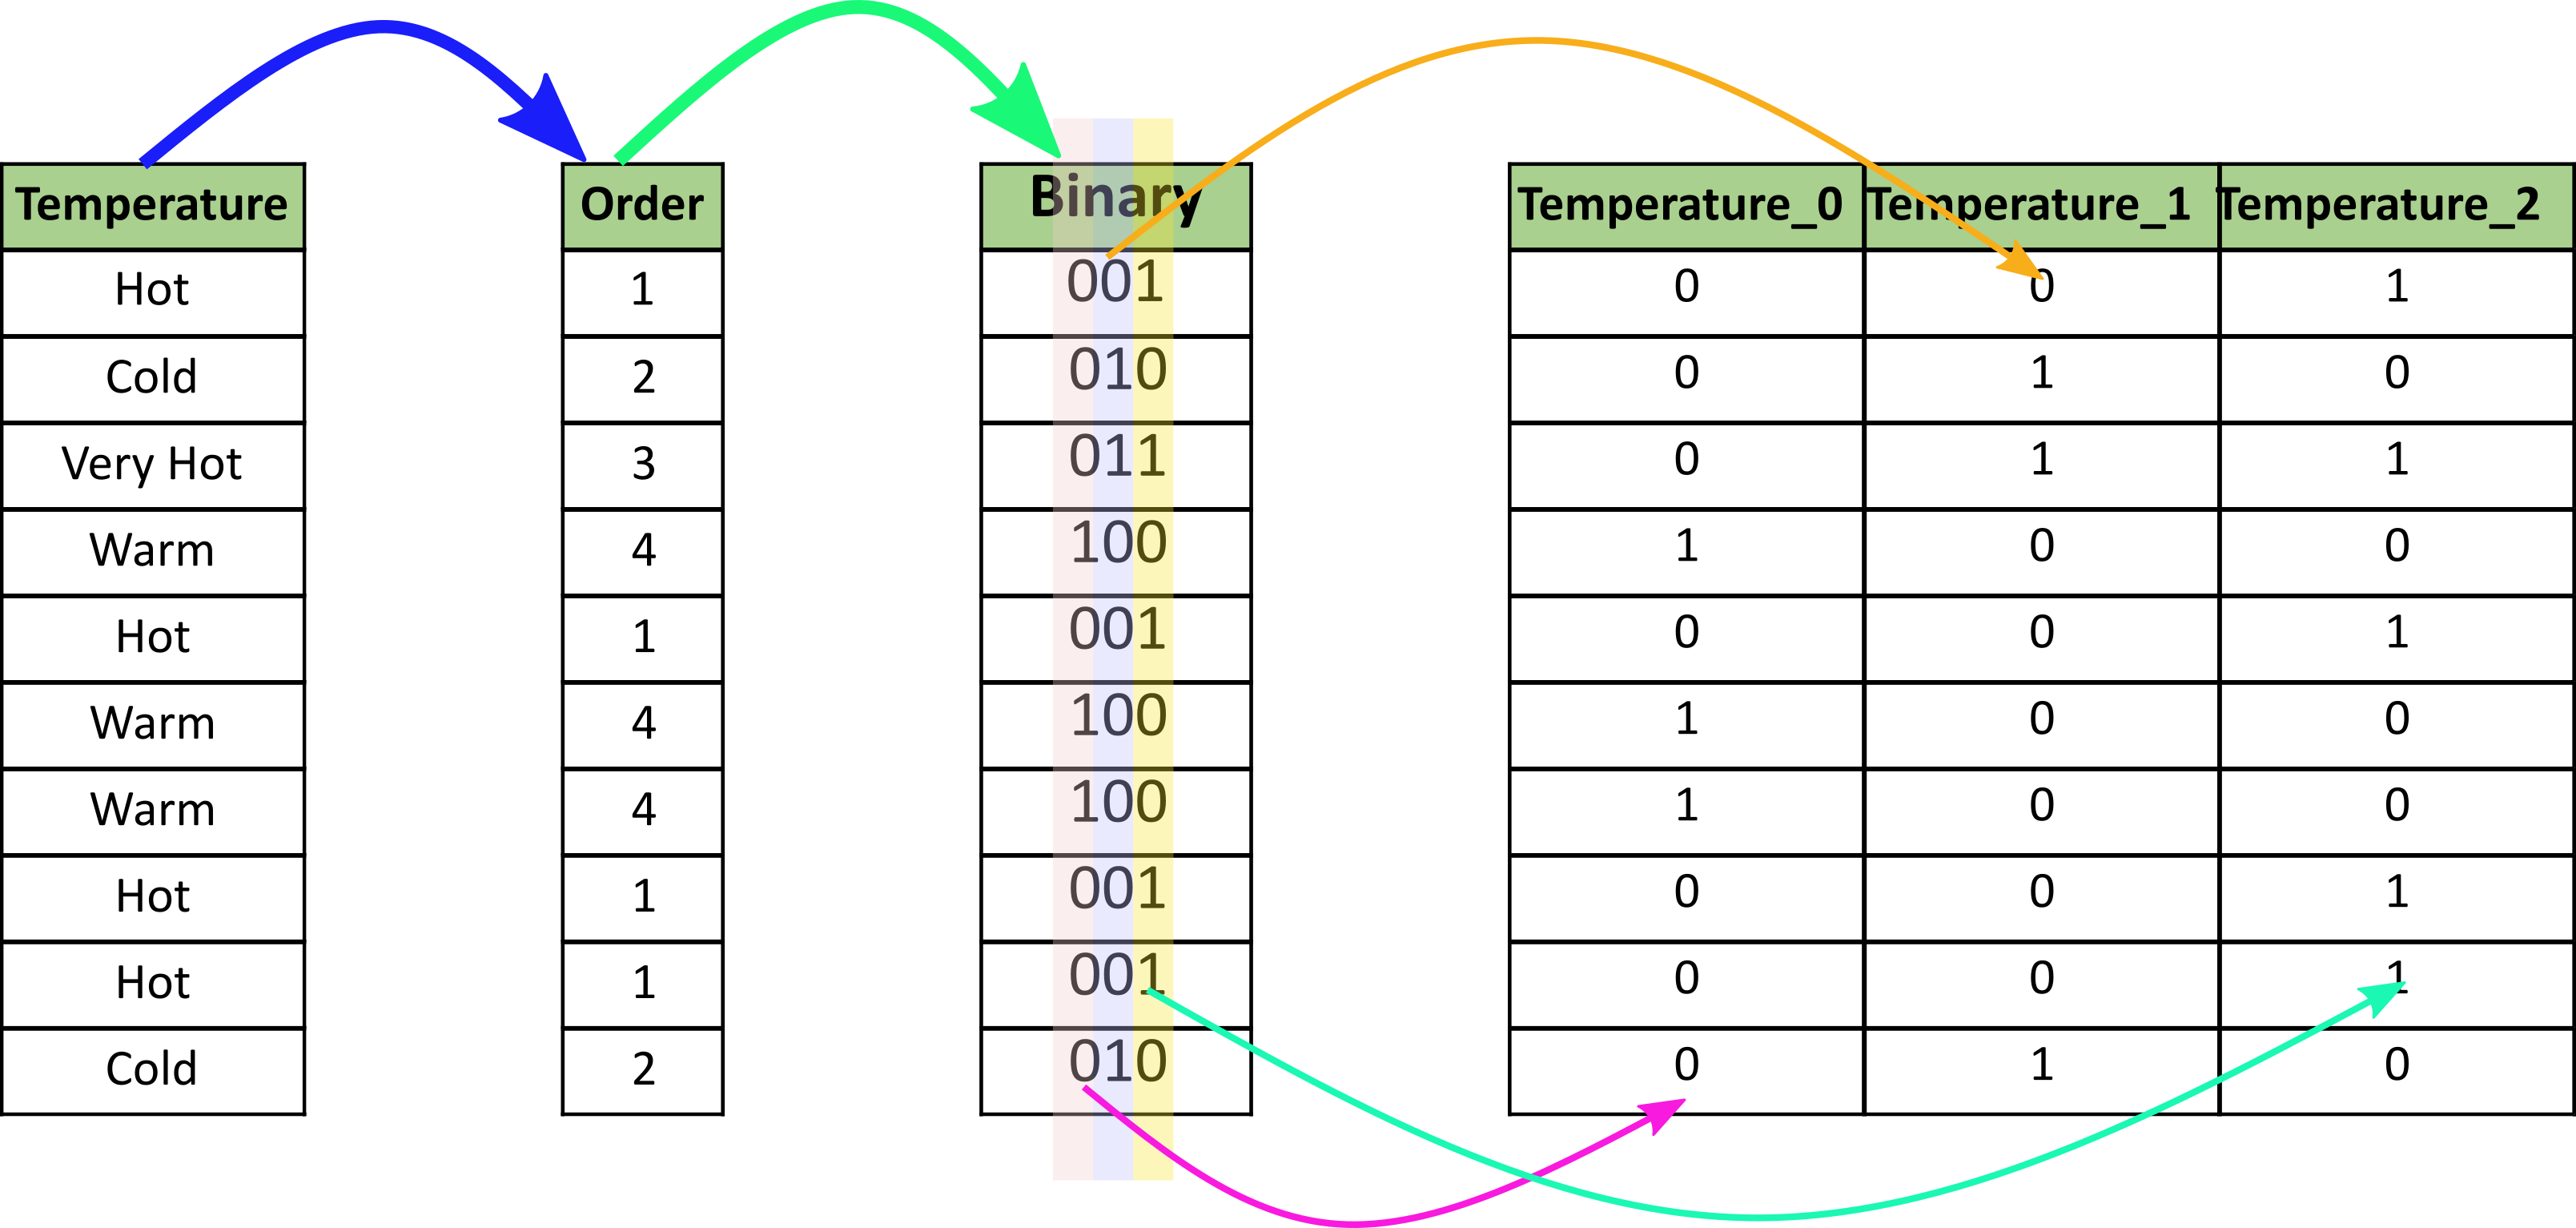

**Преобразуем категориальные признаки в численные и масштабируем количественные признаки с помощью преобразователя (transformer) столбцов `make_column_transformer`**

In [88]:
#категориальные признаки для OHE
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
#количественные признаки для StScaler
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

In [89]:
X.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,sedan,1993,manual,75.0,golf,150000,1,petrol,volkswagen,no
1,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes
2,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no
3,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


In [90]:
col_transformer = make_column_transformer(
    (
        BinaryEncoder(handle_unknown='value'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough', # will mean that all columns not specified in the list of “transformers” 
    # will be passed through without transformation, instead of being dropped.
    verbose_feature_names_out=False
)


In [91]:
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('binaryencoder', BinaryEncoder(),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('standardscaler', StandardScaler(),
                                 ['registration_year', 'power', 'kilometer',
                                  'registration_month'])],
                  verbose_feature_names_out=False)

In [92]:
X_train = pd.DataFrame(col_transformer.fit_transform(X_train), # преобразуем array 
                       columns=col_transformer.get_feature_names_out())
# check
X_train.head()
X_train.shape

(253503, 29)

In [93]:
X_train.head()

,vehicle_type_0,vehicle_type_1,vehicle_type_2,vehicle_type_3,gearbox_0,gearbox_1,model_0,model_1,model_2,model_3,...,brand_2,brand_3,brand_4,brand_5,repaired_0,repaired_1,registration_year,power,kilometer,registration_month
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.711390,0.830460,-0.109499,-0.256378
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.868509,-0.120763,-1.612890,-0.538528
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.182747,0.043241,-0.109499,-1.102828
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.082914,0.502452,0.573861,0.872221
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,-0.388443,0.830460,0.573861,-0.538528


**Трансформируем также тестовую выборку**

In [94]:
X_test = pd.DataFrame(col_transformer.transform(X_test), # преобразуем array 
                       columns=col_transformer.get_feature_names_out())
# check
X_test.head()

,vehicle_type_0,vehicle_type_1,vehicle_type_2,vehicle_type_3,gearbox_0,gearbox_1,model_0,model_1,model_2,model_3,...,brand_2,brand_3,brand_4,brand_5,repaired_0,repaired_1,registration_year,power,kilometer,registration_month
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.240033,-0.235566,0.573861,0.025772
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,-0.074205,-0.055162,0.573861,-0.538528
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.339867,0.338448,-1.066203,-1.384978
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.339867,1.060066,-0.109499,-1.384978
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.868509,-0.235566,-0.792859,-0.820678


**Вывод:**

**1. Природа данных**:
- категориальные переменные, выраженные в порядковой (год, месяц) или номинальной шкалах: `vehicle_type`, `registration_year`, `gearbox`, `model`, `registration_month`, `fuel_type`, `brand`, `repaired`, `postal_code`; 
- переменные `date_crawled`, `date_created`, `last_seen`, являются, скорее, вспомогательными для устранения аномалии в данных или дря решения других задач предобработки, впоследствии их можно будет удалить как неинформативные;
- количественные: остальные.

**2. Более 30% строк датафрейма содержали пропуски, все пропуски в столбцах, соответствующих категориальным переменным**.

**3. В результате предобработки данных**:
- удалено 5 полных дубликатов;
- типы данных во всех (оставшихся) столбцах соответствуют их природе;
- названия столбцов приведены к каноническому виду;
- выявлено, что в датафрейме имеются неинформативные столбцы: 'date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'year_created', 'month_created; удалены;
- пропуски в столбцах заполнены синтетическим данными: 
    - `repaired`: "no";
    - `model`: "unknown";
    - `fuel_type`, `vehicle_type`, `gearbox`: если они совпадали с соотв. значением 'unknown' в `model`, заполнили также - 'unknown'; остальные - модой в сгруппированных данных относительно модели;
- устранены явные аномалии в данных в объеме с соблюдением предельного значения для удаления строк из датафрейма - не более 10 %;
- после предобработки выборка составила 316879 объектов;
- категориальные признаки преобразованы в численые с помощью метода `BinaryEncoder`, что позволит избежать кратного увеличения числа столбцов в разреженной матрице (если бы использовали OHE);
- количественные переменные нормализованы (масштабированы) с помощью `StandardScaler`

---
**После предобработки данных снизилась степень рассеивания данных, по некоторым количественным признакам существенно уменьшилось std, при этом Me и Хср почти не изменились; соотношение категориальных признаков фактически не изменилось**.


    
**2. Неинформативные столбцы в данных** 
1) столбец `number_of_pictures` является неинформативным, посколько содержит только 0 значения;

2) столбец `postal_code` не представляется возможным использовать для построения модели (как и для целей предобработки).

Впоследствии удалим их.

**3. Более 30% строк датафрейма содержат пропуски, все пропуски в столбцах, соответствующих категориальным переменным**.
    
**4. Зависимая переменная `price являются количественной: классическая задача регрессии**.

**5. Тип данных, в целом, во всех столбцах, кроме `date_crawled`, `date_created`, `last_seen` (их преобразуем в date and time format), является адекватным**

## Обучение моделей

In [95]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

score = make_scorer(RMSE, greater_is_better=False)

создадим таблицу, в которой будем сохранять важные для заказчика критерии 

In [96]:
model_results = pd.DataFrame(
    columns = [
        'Модель',
        'Время на подбор параметров',
        'Время обучения',
        'Время предсказания',
        'RMSE обучающая выборка.',
        'RMSE тестовая выборка.'
    ])
model_results

,Модель,Время на подбор параметров,Время обучения,Время предсказания,RMSE обучающая выборка.,RMSE тестовая выборка.


### LinearRegression, Ridge, Lasso

#### Обучим линейную регресиию LinearRegression как базовую модель

In [97]:
LM = LinearRegression()

In [98]:
%%time
# create a KFold object with 5 splits 
time_start = time.time()
folds = KFold(n_splits = 5, shuffle = True, random_state=RANDOM_SEED)
RMSE_LM = abs(cross_val_score(LM, X_train, y_train, scoring=score, cv=folds)).mean()
print('RMSE LinearRegression:', RMSE_LM.round(2))
time_LM = time.time() - time_start
print('Time spent: {:.2f}'.format(time_LM), 's')

RMSE LinearRegression: 2938.11
Time spent: 5.04 s
CPU times: user 2.34 s, sys: 2.7 s, total: 5.05 s
Wall time: 5.04 s


In [99]:
time_LM = round(time_LM,2)

#### Обучим линейную регресиию с регуляризацией - Ridge

In [100]:
params_ridge = {"alpha": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

In [101]:
grid_ridge = GridSearchCV( 
    estimator=Ridge(random_state=RANDOM_SEED),
    param_grid = params_ridge,
    cv=folds, # take 5 folds
    scoring=score,
    verbose=10,
    n_jobs=-1)

In [102]:
%%time
time_start = time.time()
grid_ridge.fit(X_train, y_train)
time_Ridge = time.time() - time_start

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5; 1/28] START alpha=0.0001...............................................
[CV 1/5; 1/28] END ............alpha=0.0001;, score=-2926.580 total time=   0.2s
[CV 2/5; 1/28] START alpha=0.0001...............................................
[CV 2/5; 1/28] END ............alpha=0.0001;, score=-2942.773 total time=   0.2s
[CV 3/5; 1/28] START alpha=0.0001...............................................
[CV 3/5; 1/28] END ............alpha=0.0001;, score=-2964.509 total time=   0.3s
[CV 4/5; 1/28] START alpha=0.0001...............................................
[CV 4/5; 1/28] END ............alpha=0.0001;, score=-2919.188 total time=   0.2s
[CV 5/5; 1/28] START alpha=0.0001...............................................
[CV 5/5; 1/28] END ............alpha=0.0001;, score=-2934.632 total time=   0.3s
[CV 1/5; 2/28] START alpha=0.001................................................
[CV 1/5; 2/28] END .............alpha=0.001;, s

In [103]:
print('Лучшая модель Ridge:', grid_ridge.best_estimator_)
print('Лучшие параметры Ridge:', grid_ridge.best_params_)
print('The best mean_squared_error', abs(grid_ridge.best_score_))
print('Time spent: {:.2f}'.format(time_Ridge), 's')

Лучшая модель Ridge: Ridge(alpha=9.0, random_state=42)
Лучшие параметры Ridge: {'alpha': 9.0}
The best mean_squared_error 2937.535975510128
Time spent: 37.10 s


#### Обучим линейную регресиию с регуляризацией Lasso

In [104]:
grid_lasso = GridSearchCV( 
    estimator=Lasso(random_state=RANDOM_SEED),
    param_grid = params_ridge,
    cv=folds, # take 5 folds
    scoring=score,
    verbose=10,
    n_jobs=-1)

In [105]:
%%time
time_start = time.time()
grid_lasso.fit(X_train, y_train)
time_Lasso = time.time() - time_start

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5; 1/28] START alpha=0.0001...............................................
[CV 1/5; 1/28] END ............alpha=0.0001;, score=-2926.580 total time= 1.8min
[CV 2/5; 1/28] START alpha=0.0001...............................................
[CV 2/5; 1/28] END ............alpha=0.0001;, score=-2942.773 total time= 1.8min
[CV 3/5; 1/28] START alpha=0.0001...............................................
[CV 3/5; 1/28] END ............alpha=0.0001;, score=-2964.509 total time= 2.3min
[CV 4/5; 1/28] START alpha=0.0001...............................................
[CV 4/5; 1/28] END ............alpha=0.0001;, score=-2919.188 total time= 1.6min
[CV 5/5; 1/28] START alpha=0.0001...............................................
[CV 5/5; 1/28] END ............alpha=0.0001;, score=-2934.632 total time= 1.5min
[CV 1/5; 2/28] START alpha=0.001................................................
[CV 1/5; 2/28] END .............alpha=0.001;, s

In [106]:
print('Лучшая модель Lasso:', grid_lasso.best_estimator_)
print('Лучшие параметры Lasso:', grid_lasso.best_params_)
print('The best mean_squared_error', abs(grid_lasso.best_score_))
print('Time spent: {:.2f}'.format(time_Lasso), 's')

Лучшая модель Lasso: Lasso(alpha=0.0001, random_state=42)
Лучшие параметры Lasso: {'alpha': 0.0001}
The best mean_squared_error 2937.536253833499
Time spent: 3913.44 s


**Видим, что качество линейных моделей фактически не "лечится" регуляризацией: видимо в данных сложные нелинейные закономерности. Учитывая время, затраченное на обучение модели, лучший результат у базовой модели ленейной регрессии**

In [107]:
model_results.loc[ len(model_results.index )] = ['LinearRegression', '---', time_LM, '---', RMSE_LM, '---']

In [108]:
model_results

,Модель,Время на подбор параметров,Время обучения,Время предсказания,RMSE обучающая выборка.,RMSE тестовая выборка.
0,LinearRegression,---,5.04,---,2938.11046,---


### DT_Regressor, RF_Regressor

#### DT_Regressor

In [109]:
params_DT={'max_depth':list(np.arange(2, 50, step=1)) + [None]}
params_RF = {
    'max_depth':[5, 10, 20],
    'n_estimators': [10, 50, 100]
}

In [110]:
folds = KFold(n_splits = 3, shuffle = True, random_state=RANDOM_SEED)

In [111]:
grid_DT = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid = params_DT,
    cv=folds, # take 5 folds
    scoring=score,
    verbose=10,
    n_jobs=-1)

In [112]:
%%time
time_start = time.time()
grid_DT.fit(X_train, y_train)
time_DT = time.time() - time_start

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV 1/3; 1/49] START max_depth=2................................................
[CV 1/3; 1/49] END .............max_depth=2;, score=-2999.464 total time=   0.3s
[CV 2/3; 1/49] START max_depth=2................................................
[CV 2/3; 1/49] END .............max_depth=2;, score=-3012.849 total time=   0.2s
[CV 3/3; 1/49] START max_depth=2................................................
[CV 3/3; 1/49] END .............max_depth=2;, score=-2978.092 total time=   0.2s
[CV 1/3; 2/49] START max_depth=3................................................
[CV 1/3; 2/49] END .............max_depth=3;, score=-2750.312 total time=   0.3s
[CV 2/3; 2/49] START max_depth=3................................................
[CV 2/3; 2/49] END .............max_depth=3;, score=-2769.757 total time=   0.3s
[CV 3/3; 2/49] START max_depth=3................................................
[CV 3/3; 2/49] END .............max_depth=3;, s

In [113]:
print('Лучшая модель DT:', grid_DT.best_estimator_)
print('Лучшие параметры DT:', grid_DT.best_params_)
print('The best RMSE', abs(grid_DT.best_score_))
print('Time spent: {:.2f}'.format(time_DT), 's')

Лучшая модель DT: DecisionTreeRegressor(max_depth=14, random_state=42)
Лучшие параметры DT: {'max_depth': 14}
The best RMSE 1874.873597489429
Time spent: 193.49 s


In [114]:
DT = grid_DT.best_estimator_ # save model
DT_RMSE = abs(grid_DT.best_score_) # save score
time_DT = round(time_DT, 2)

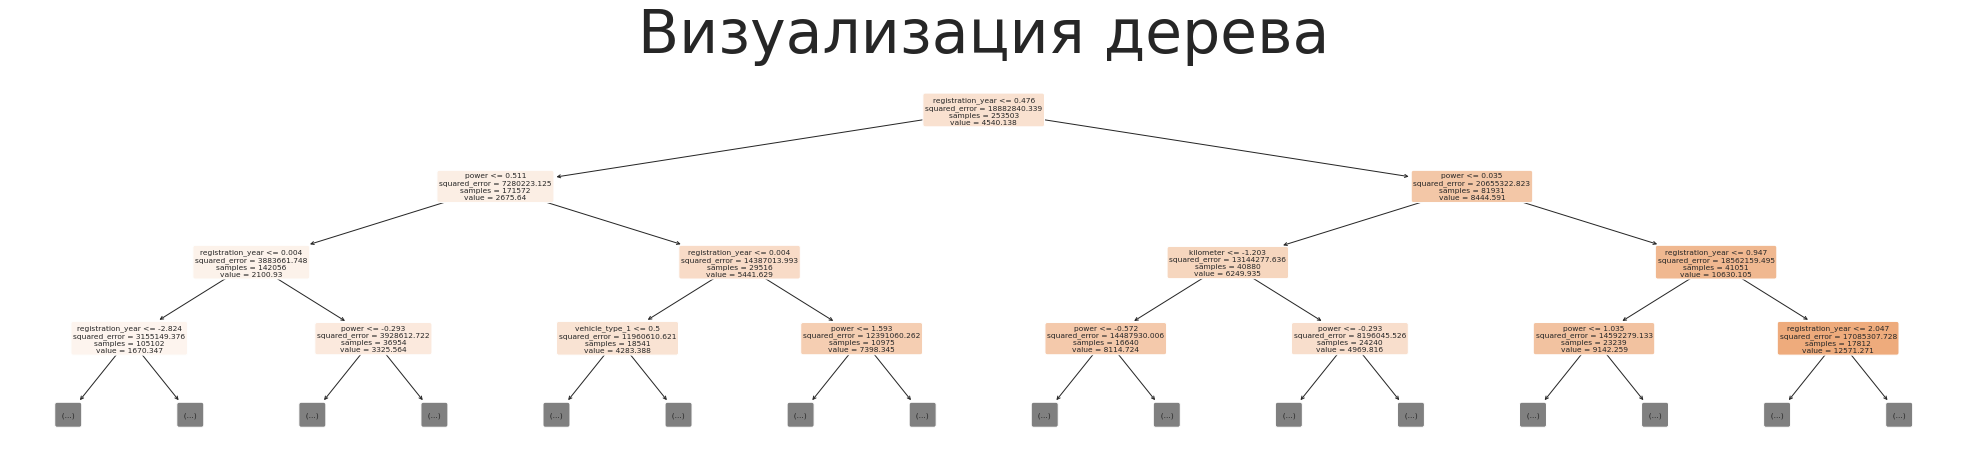

In [115]:
fig = plt.figure(figsize=(35,7))
tree.plot_tree(DT,
               max_depth=3,
               filled=True,
               rounded=True,
               feature_names=X_train.columns,
               class_names=True
              )
plt.title('Визуализация дерева', fontsize=60, pad='20.0')
plt.show()

In [116]:
pd.DataFrame({'feature': X_train.columns,
              'importance': DT.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
25,registration_year,0.580589
26,power,0.266278
27,kilometer,0.045901
1,vehicle_type_1,0.014528
28,registration_month,0.007666
3,vehicle_type_3,0.007308
23,repaired_0,0.006439
24,repaired_1,0.006183
18,brand_1,0.005750
15,fuel_type_1,0.005402


#### RF_Regressor

**Попробуем подобрать лучшие параметры для лучшей модели RF, комбинируя метод AutoML - RandomizedSearchCV & перебор гиперпараметров в циклах:**

1) сначала попробуем пройтись RandomizedSearchCV по параметрам "крупными мазками";

2) далее - на циклах по параметрам в заданном диапазоне, определенном по результатам шага 1.

---
*Дабы не грузить сервер, диапазон поиска по гиперпараметрам может быть сужен*

In [117]:
random_RF = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_SEED, oob_score=True),
    param_distributions=params_RF,
    cv=folds, # take 3 folds
    scoring=score,
    n_iter=20,
    n_jobs=-1,
    verbose=10)

In [118]:
%%time
time_start = time.time()
random_RF.fit(X_train, y_train)
time_RFrandom = time.time() - time_start

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START max_depth=5, n_estimators=10................................
[CV 1/3; 1/9] END max_depth=5, n_estimators=10;, score=-2264.795 total time=   2.8s
[CV 2/3; 1/9] START max_depth=5, n_estimators=10................................
[CV 2/3; 1/9] END max_depth=5, n_estimators=10;, score=-2291.641 total time=   3.0s
[CV 3/3; 1/9] START max_depth=5, n_estimators=10................................
[CV 3/3; 1/9] END max_depth=5, n_estimators=10;, score=-2268.575 total time=   3.2s
[CV 1/3; 2/9] START max_depth=5, n_estimators=50................................
[CV 1/3; 2/9] END max_depth=5, n_estimators=50;, score=-2265.140 total time=  15.0s
[CV 2/3; 2/9] START max_depth=5, n_estimators=50................................
[CV 2/3; 2/9] END max_depth=5, n_estimators=50;, score=-2287.233 total time=  14.6s
[CV 3/3; 2/9] START max_depth=5, n_estimators=50................................
[CV 3/3; 2/9] END max_depth=5, n_e

In [119]:
print('Лучшая модель random_RF:', random_RF.best_estimator_)
print('Лучшие параметры random_RF:', random_RF.best_params_)
print('The best RMSE', abs(random_RF.best_score_))
print('Time spent: {:.2f}'.format(time_RFrandom), 's')
time_RFrandom = round(time_RFrandom, 2)

Лучшая модель random_RF: RandomForestRegressor(max_depth=20, oob_score=True, random_state=42)
Лучшие параметры random_RF: {'n_estimators': 100, 'max_depth': 20}
The best RMSE 1566.6757240586855
Time spent: 940.71 s


In [120]:
best_model_RF = None 
best_score_RF = 2500
time_start = time.time()

for est in tqdm(range(110,112)): 
    for depth in range(18,20):
        RF = RandomForestRegressor(random_state=RANDOM_SEED,
                                    oob_score=True,
                                    n_estimators = est,
                                    max_depth = depth)
    
        cross_val_score_RF = abs(cross_val_score(RF, X_train, y_train, cv=folds, scoring=score).mean())

        if cross_val_score_RF < best_score_RF:
            best_model_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_score_RF = cross_val_score_RF
            print('деревьев:', best_est_RF, 'глубина:', best_depth_RF, 'RMSE:', best_score_RF)
time_RF = time.time() - time_start
print("RMSE наилучшей модели:", best_score_RF,
      "\nКоличество деревьев:", best_est_RF,
      "\nГлубина наилучшей модели:", best_depth_RF,
      'Time spent: {:.2f}'.format(time_RF), 's',
      "\nмодель:", best_model_RF
     )

  0%|          | 0/2 [00:00<?, ?it/s]

деревьев: 110 глубина: 18 RMSE: 1566.6828856672093


 50%|█████     | 1/2 [09:20<09:20, 560.91s/it]

деревьев: 110 глубина: 19 RMSE: 1564.9484167984854


 50%|█████     | 1/2 [10:37<10:37, 637.12s/it]


KeyboardInterrupt: 

In [ ]:
time_RFloop = round(time_RF, 2)
time_RFloop

In [ ]:
%%time
time_start = time.time()
best_model_RF.fit(X_train, y_train)
time_RFfit = time.time() - time_start
print('Time spent: {:.2f}'.format(time_RFfit), 's')
time_RFfit = round(time_RFfit, 2)

In [ ]:
feature_importance = pd.DataFrame({'feature': X_train.columns,
              'importance': best_model_RF.feature_importances_}).sort_values('importance', ascending=False)

In [ ]:
sns.set(rc={'figure.figsize':(22,12)})

ax = sns.barplot(y=feature_importance['feature'], x=feature_importance['importance'])
plt.bar_label(ax.containers[0], fmt='%.2f', padding=10, color = 'red')
plt.title('Важность признаков для построения модели', fontsize=30)
plt.yticks(fontsize=15)
plt.show()

**Видим, что даже суммарный вклад всех признаков, помимо пробега, мощности и года регистрации автомобиля, составляет менее 5 %**
Интересно, что информативность пробега также сравнительно невысокая.

In [ ]:
%%time
time_start = time.time()

predictions = best_model_RF.predict(X_test)
RMSE_test = mean_squared_error(y_test, predictions) ** 0.5
time_RFpred = time.time() - time_start
RMSE_test

In [ ]:
print('Time spent: {:.2f}'.format(time_RFpred), 's')
time_RFpred = round(time_RFpred, 2)
time_RFparams = time_RFrandom + time_RFloop

In [ ]:
model_results.loc[ len(model_results.index )] = ['RandomForestRegressor', time_RFparams, time_RFfit, time_RFpred, best_score_RF, RMSE_test]

In [ ]:
model_results

### XGBRegressor, LightGBM, CatBoostRegressor

#### XGBRegressor

Должен быть более эффективным чем классический GBM засчет:
- не проверяем каждый узел на предмет того, можно ли его разделить, а заранее задаем глубину (*Level-wise Tree Growth*): вроде бы, должны выигрывать в скорости;
- отсекаем листья (по критерию информативности);
- используем регуляризацию

посмотрим как долго будет обучаться модель by default, без указания параметров

In [ ]:
%%time
XGB_base = xgb.XGBRegressor(random_state=RANDOM_SEED, verbosity=2)
RMSE_XGB_base = abs(cross_val_score(XGB_base, X_train, y_train, scoring=score, cv=folds)).mean()
print('RMSE:', RMSE_XGB_base.round(2))

In [ ]:
XGB_base

Модель обучалась довольно долго, существенно дольше того же RF (117 сек). 

---
Как известно, эффективность алгоритма XGBoost кроется в правильно подобранных параметрах модели, которые в данно случае довольно разнообразны. Диапазон параметров, указанных ниже, существенно уже того, который я использовал (в целях экономии времени при очередных загрузках ноутбука).

In [ ]:
params_XGB = {
    'learning_rate':[0.1], # коэфициент скорости обучения, используемый для предотвращения переобучения
    'gamma':[0.01],
    'max_depth':[6, 13],
#     'min_child_weight':list(np.arange(1, 8, step=1)),
#     'subsample':[0.5, 0.8], #процент использованных объектов в выборке на дерево. Низкое значение может привести к неполному оснащению
#     'colsample_bytree':[0.3, 0.6, 0.8, 1], # процент признаков, используемых в дереве; высокое значение может привести к переобучению.
    'reg_lambda':[3],
    'reg_alpha':[0], # более агрессивная l1-регуляризация весов листьев
    'n_estimators':[20, 100]
}
fit_params_XGB = {'early_stopping_rounds':5,
                  'eval_metric': 'rmse',
                  'eval_set':[[X_train, y_train]]} 

Сначала подбираем хорошую "окрестность" гиперпараметров с помощью RandomizedSearchCV (реально, конечно, использовался гораздо более широкий диапазон гиперпараметров модели, здесь важно сравнить временные затраты с другими моделями ML)

In [ ]:
random_XGB = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(random_state=RANDOM_SEED, verbosity=2),
    param_distributions=params_XGB,
    cv=3, # take 3 folds
    scoring=score,
    n_iter=20,
    n_jobs=-1,
    verbose=10)

In [ ]:
%%time
time_start = time.time()
random_XGB.fit(X_train, y_train, **fit_params_XGB)
time_XGBrandom = time.time() - time_start

In [ ]:
print('Лучшая модель XGBRegressor:', random_XGB.best_estimator_)
print('Лучшие параметры XGBRegressor:', random_XGB.best_params_)
print('The best RMSE', abs(random_XGB.best_score_))
print('Time spent: {:.2f}'.format(time_XGBrandom), 's')
time_XGBrandom = round(time_XGBrandom, 2)

In [ ]:
best_model_RF_XGB = None 
best_score_RF_XGB = 2500
list_lr = [0.1]
time_start = time.time()

fit_params = {'early_stopping_rounds': 5, 
            'eval_metric': 'rmse',
            'verbose': True,
            'eval_set': [[X_train, y_train]]}

for lr in list_lr: 
    for est in tqdm(range(150,151)): 
        for depth in range(11,12):
            RF_XGB = xgb.XGBRegressor(random_state=RANDOM_SEED,
                                      learning_rate=lr,
                                      n_estimators = est,
                                      max_depth = depth,
                                      min_child_weight=3,
                                      subsample=0.9,
                                      gamma=0.01,
                                      reg_lambda=3)
    
            cross_val_score_RF_XGB = abs(cross_val_score(RF_XGB, X_train, y_train, cv=3, scoring=score, fit_params = fit_params).mean())
            if cross_val_score_RF_XGB < best_score_RF_XGB:
                best_model_RF_XGB = RF_XGB
                best_lr_RF_XGB = lr
                best_depth_RF_XGB = depth
                best_est_RF_XGB = est
                best_score_RF_XGB = cross_val_score_RF_XGB
                print('learning_rate', best_lr_RF_XGB,
                      'деревьев:', best_est_RF_XGB,
                      'глубина:', best_depth_RF_XGB,
                      'RMSE:', best_score_RF_XGB)
time_XGBloop = time.time() - time_start
print("RMSE наилучшей модели RF_XGB:", best_score_RF_XGB,
      "\nlearning rate RF_XGB:", best_lr_RF_XGB,
      "\nКоличество деревьев RF_XGB:", best_est_RF_XGB,
      "\nГлубина наилучшей модели RF_XGB:", best_depth_RF_XGB,
      '\nTime spent: {:.2f}'.format(time_XGBloop), 's',
      "\nмодель:", best_model_RF_XGB)

In [ ]:
time_XGBloop = round(time_XGBloop, 2)
time_XGBloop

In [ ]:
%%time
time_start = time.time()
best_model_RF_XGB.fit(X_train, y_train)
time_XGBfit = time.time() - time_start
print('Time spent: {:.2f}'.format(time_XGBfit), 's')
time_XGBfit = round(time_XGBfit, 2)

In [ ]:
best_model_RF_XGB.feature_importances_

In [ ]:
from xgboost import plot_importance

plot_importance(best_model_RF_XGB, height=0.5, max_num_features=10)

plt.show()

*в документации указано, что by default importance_type = "weight", it is the number of times a feature appears in a tree*

**ТОП-10 важнных признаков, использованных при построении модели. Видим, что чаще других признаков использовался `power`, неожиданно месяц регистрации более частотен по сравнению с пробегом, также сравнительно часто использовались нек. переменые со значениями признаков типа кузова, марки и модели**

In [ ]:
%%time
time_start = time.time()

predictions = best_model_RF_XGB.predict(X_test)
RMSE_test_XGB = mean_squared_error(y_test, predictions) ** 0.5
time_XGBpred = time.time() - time_start
RMSE_test_XGB

In [ ]:
print('Time spent: {:.2f}'.format(time_XGBpred), 's')
time_XGBpred = round(time_XGBpred, 2)

In [ ]:
time_XGBparams = time_XGBrandom + time_XGBloop

In [ ]:
model_results.loc[ len(model_results.index )] = ['XGBRegressor',
                                                 time_XGBparams, time_XGBfit, time_XGBpred, best_score_RF_XGB, RMSE_test_XGB]

In [ ]:
model_results

#### LightGBM

**LightGBM должен обучиться в разы быстрее, чем XGB:**

- модель строится не на всех наблюдениях, а на опр. подвыборке - **GOSS**, на основе значений градиента:
    - основная идея состоит в том, что для расчетов при построении деревьев берутся не все наблюдения, а **GOSS** - односторонняя выборка на основе градиента. GOSS присваивает наблюдениям с большими градиентами и соответственно с большими ошибками более высокий вес. Таким образом, экземпляры, которые недостаточно использовались для обучения, вносят больший вклад. Наблюдения с меньшими градиентами удаляются случайным образом, некоторые из них сохраняются для поддержания точности.

- встроенная кодировка категориальных переменных, которая позволяет связывать переменные, принимающие одновременно ненулевые значения, друг с другом;

- *Level-wise Tree Growth*: LightGBM создает деревья решений, которые растут по листам, что означает, что при заданном условии разделяется только один лист (а не 2 как в XGB), тот, который дает больший прирост информации; при этом деревья с большим числом листьев иногда могут переобучаться, особенно с небольшими наборами данных; ограничение глубины дерева может помочь избежать переобучения.

In [ ]:
params_LGBM = {'num_leaves': [40, 80],
               'num_iterations': [10, 100],
               'max_depth': [5, 20],
               'lambda_l2':[1],
               'learning_rate':[0.1], 
               'bagging_fraction':[0.8] }

In [ ]:
fit_params = {'early_stopping_rounds': 5, 
            'eval_metric': 'rmse',
            'verbose': True,
            'eval_set': [[X_train, y_train]]}

In [ ]:
random_LGBM = RandomizedSearchCV(
    estimator = LGBMRegressor(random_state=RANDOM_SEED, verbosity=-1),
    param_distributions=params_LGBM,
    cv=3, # take 3 folds
    scoring=score,
    n_iter=20,
    n_jobs=-1,
    verbose=10)

In [ ]:
%%time
time_start = time.time()
random_LGBM.fit(X_train, y_train, **fit_params)
time_LGBMrandom = time.time() - time_start

In [ ]:
print('Лучшая модель LGBMRegressor:', random_LGBM.best_estimator_)
print('Лучшие параметры LGBMRegressor:', random_LGBM.best_params_)
print('The best RMSE', abs(random_LGBM.best_score_))
print('Time spent: {:.2f}'.format(time_LGBMrandom), 's')
time_LGBMrandom = round(time_LGBMrandom, 2)

In [ ]:
parameters_grid_LGBM = {'max_depth': [10,20],
                       'n_estimators': [150, 1000],
                        'bagging_fraction':[0.5],
                        'num_leaves': [40,80]
                      }

In [ ]:
grid_LGBM = GridSearchCV( 
    estimator=LGBMRegressor(random_state=RANDOM_SEED, verbosity=2,
                              learning_rate=0.1,
                              lambda_l2=1),
    param_grid = parameters_grid_LGBM,
    cv=3, # take 3 folds
    scoring=score,
    verbose=10,
    n_jobs=-1)

In [ ]:
%%time
time_start = time.time()
grid_LGBM.fit(X_train, y_train, **fit_params)
time_LGBMgrid = time.time() - time_start

In [ ]:
print('Лучшая модель LGBMRegressor:', grid_LGBM.best_estimator_)
print('Лучшие параметры LGBMRegressor:', grid_LGBM.best_params_)
print('The best RMSE', abs(grid_LGBM.best_score_))

print('Time spent: {:.2f}'.format(time_LGBMgrid), 's')
time_LGBMgrid = round(time_LGBMgrid, 2)

In [ ]:
best_model_LGBM = grid_LGBM.best_estimator_

In [ ]:
%%time
time_start = time.time()
best_model_LGBM.fit(X_train, y_train)
time_LGBMfit = time.time() - time_start
print('Time spent: {:.2f}'.format(time_LGBMfit), 's')
time_LGBMfit = round(time_LGBMfit, 2)

In [ ]:
feature_importance = best_model_LGBM.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

LightGBM имеет внутренние способы оценки важности признаков - на основе того, как часто делается сплит в вершине по признаку (split) и на основе того, какой суммарный прирост в информации дает разбиение по признаку (gain). Насколько понимаю, при построении графика использовался первый способ оценки важности признаков. Впоследствии, при доработке модели, можно отобрать топ признаков по важности и построить более качественную модель.

**Видим, что самый важный признак для модели - мощность двигателя; год регистрации - 2е место, 3е место неожиданно за месяцем регистрации; в целом, видно, что модель учитывает категориальные признаки при минимизации функции потерь (в целом, устройство модели позволяет не реализовывать предварительно кодирование категориальных признаков), отметим, что учитывается важно типа КПП**

In [ ]:
%%time
time_start = time.time()

predictions = best_model_LGBM.predict(X_test)
RMSE_test_LGBM = mean_squared_error(y_test, predictions) ** 0.5
time_LGBMpred = time.time() - time_start
RMSE_test_LGBM

In [ ]:
print('Time spent: {:.2f}'.format(time_LGBMpred), 's')
time_LGBMpred = round(time_LGBMpred, 2)

In [ ]:
time_LGBMparams = time_LGBMrandom + time_LGBMgrid

In [ ]:
model_results.loc[ len(model_results.index )] = ['LGBMRegressor',
                                                 time_LGBMparams, time_LGBMfit,
                                                 time_LGBMpred, abs(grid_LGBM.best_score_), RMSE_test_LGBM]

In [ ]:
model_results

#### CatBoostRegressor

**CatBoost** — это библиотека градиентного бустинга, созданная Яндексом. Она использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (split) на каждом уровне дерева; параметры для разделения узлов подбираются на всем фрейме, перед каждой итерацией, затем ранжируются по важности и используются при симметричном разделении узлов от корней до листьев, что существенно позволяет сократить время на обучение

**Ordered boosting**: на каждой итерации обучение и прогноз присходят на разных подвыборках

**Ordered target-encoding:** позволяет упорядочить наблюдения в соответствии с их расположения в выборке и не "раздувать" размерность по сравнению с OHE

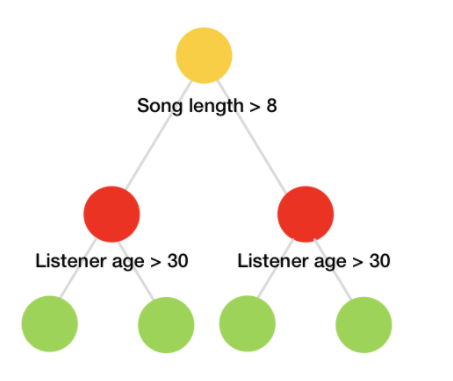

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
(
    X_train_cat, 
    X_test_cat,
    y_train_cat,
    y_test_cat) = train_test_split(X,
                               y,
                               test_size=0.2,
                               random_state=RANDOM_SEED,
                               shuffle=True
                              ) # разделим данные на обучающую и тестовую выборки

In [ ]:
#категориальные признаки
cat_features = X_train_cat.select_dtypes(include='object').columns.to_list()
#количественные признаки для StScaler
num_features = X_train_cat.select_dtypes(exclude='object').columns.to_list()

In [ ]:
cat_features

In [ ]:
def scaling(df_train, df_test):
    SS = StandardScaler()
    data_train = SS.fit_transform(df_train)
    data_test = SS.transform(df_test)

    return data_train, data_test

In [ ]:
X_train_cat[num_features], X_test_cat[num_features] = scaling(X_train_cat[num_features], X_test_cat[num_features])

In [ ]:
X_train_cat.head()

In [ ]:
params_CatBoost = {'iterations': [150, 1000],
                   'depth': [10, 20],
                   'learning_rate':[0.1],
                   'l2_leaf_reg': [1]}

In [ ]:
cbr = CatBoostRegressor(iterations=50,
                        learning_rate=1,
                        verbose=True,
#                         loss_function='rmse',
                        early_stopping_rounds=5,
                        cat_features=cat_features,
                        random_seed=RANDOM_SEED)

In [ ]:
%%time
time_start = time.time()
random_CatBoost_result = cbr.randomized_search(param_distributions=params_CatBoost,
                                               cv=3,
                                               n_iter=20,
                                               shuffle=True,
                                               X=X_train_cat,
                                               y=y_train_cat,
                                               plot=True)
time_CatBoostrandom = time.time() - time_start

In [ ]:
cbr.get_params()

In [ ]:
best_score_cbr = cbr.get_best_score()['learn']['RMSE']
best_score_cbr

In [ ]:
%%time
time_start = time.time()
cbr.fit(X_train_cat, y_train_cat)
time_cbrfit = time.time() - time_start
print('Time spent: {:.2f}'.format(time_cbrfit), 's')
time_cbrfit = round(time_cbrfit, 2)

In [ ]:
%%time
time_start = time.time()

predictions = cbr.predict(X_test_cat)
RMSE_test_cbr = mean_squared_error(y_test_cat, predictions) ** 0.5
time_cbrpred = time.time() - time_start
RMSE_test_cbr

In [ ]:
feature_importance = cbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train_cat.columns)[sorted_idx])
plt.title('Feature Importance')

**Видим, что самый важный признак для модели - год регистрации; мощность двигателя - 2е место, 3е место неожиданно за маркой автомобиля (видимо, сработало упорядоченное таргет-кодирование); в целом, видно, что модель учитывает категориальные признаки при минимизации функции потерь (видимо, так работает упорядоченное кодирование**

In [ ]:
print('Time spent: {:.2f}'.format(time_cbrpred), 's')
time_cbrpred = round(time_cbrpred, 2)

In [ ]:
model_results.loc[ len(model_results.index )] = ['CatBoostRegressor',
                                                 time_CatBoostrandom, time_cbrfit,
                                                 time_cbrpred, best_score_cbr, RMSE_test_cbr]

Хорошая картинка)

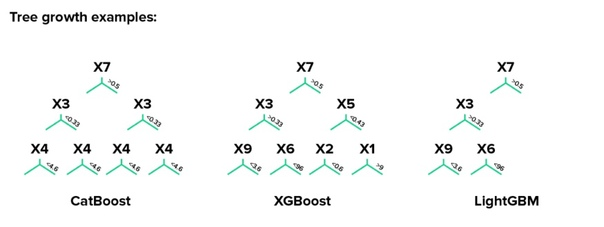

**Выводы по главе 2:**

1. **Линейные модели** не смогли достичь порогового значения качества - RMSE: 2500, поэтому их можно не рассматривать.

2. Все модели (кроме линейных) имеют разное соотношение качества предсказания, скорости подбора гиперпараметров, скорости обучения и предсказания, при этом соотношения абсолютных показателей RMSE на тестовой выборке имеют "близкие" значения.

3. Модели, основаннные на градиентном бустине, имеют заметно лучшие значения RMSE на тестовой выборке по сравнению с классическими DT & RF.

4. По результатам оценки важности признаков (feature importanc) или степени влияния этого признака на целевой признак при построении моделей можно отметить:

- **Классический Random_Forest**:
    - учтены, в основном, количественные признаки: суммарный вклад всех признаков, помимо пробега, мощности и года регистрации автомобиля, составляет менее 5 %, то есть они не являюся информативными для построенных деревьев;
    - ТОП-3: год регистрации, мощность, пробег;
    - интересно, что важность фичей соответствует зналичию линейных связей по критерию Пирсона между целевым признаком и данными: **видимо, модель не смогла уловить какие-то сложные нелинейные закономерности в данных**;

- **XGBRegressor**:
    - в ТОП-10 информативных признаков попали категориальные: тип кузова, марка и модель;
    - ТОП-3: мощность, год регистрации, месяц регистрации (после - пробег);
- **LGBMRegressor**:
    - в ТОП-10 информативных признаков попали категориальные: тип кузова, марка, модель и тип КПП; наимение информативны 'fuel_type', 'repaired'
    - ТОП-3: мощность, год регистрации, месяц регистрации (после - пробег);
- **CatBoostRegressor**:
    - категориальные признаки наиболее информативны по сравнению с другим моделями: наименее информативен тип КПП, наличие ремонта и месяц регистрации;
    - ТОП-3: год регистрации (с существенным отрывом), мощность, марка;
---
**Самый информативный признак - "год регистрации авто", также важен "пробег", наимение информативен 'repaired'**

## Анализ моделей

Проанализируем все модели по критериям: время обучения, время предсказания и качество

In [ ]:
model_results

1. **Линейные модели** не смогли достичь порогового значения качества - RMSE: 2500, поэтому их можно не рассматривать.

2. **Классический Random_Forest** предсказывает ок. 2 сек., довольно быстро обучается (116.7 сек.), имеет худшие показатели RMSE на обучающей и тестовой выборках, соответственно: 1564 и 1524.

3. Все **модели, основанные на градиентном бустинге,** имеют более низкие значения RMSE на обучающей и тестовой выборках по сравнению с классическим "случайным лесом". `XGBRegressor` из бустинговых моделей выделяется также не в лучшую сторону: очень медленно перебирает гиперпараметры, медленно обучается на заданных гипепарамтерах, хотя довольно быстро делает предсказания + имеет 2й по качеству RMSE на тестовой выборке.
    
4. **Время, затраченное на обучение** 

- худшие показатели у XGBRegressor, лучшие показатели у CatBoostRegressor.

5. **Время, затраченное на предсказание** 

- худшие показатели у LGBMRegressor - 8.5 сек., CatBoostRegressor и XGB предсказывают менее чем за 1 секунду.

<div style="border:solid green 3px; padding: 20px">
<font size="4"><b>Заказчику</b></font>

По обозначенным критериям (время обучения, предсказания + качество) можно выделить 2-модели - LGBMRegressor & CatBoostRegressor.
В зависимости от приоритетов по данным критериям рекомендуется отдать предпочтение:
    
1) <font size="2"><b>LGBMRegressor</b></font>: если захочется получить более точный прогноз, еще есть над чем поработать, соответственно потребуется дообучение или переобоучение: LGBMRegressor учиться кратно быстрее (если это существенно для Заказчика) + имеет чуть лучший показатель RMSE по сравнению c CatBoostRegressor;
    
2) <font size="2"><b>CatBoostRegressor</b></font>: если важна скорость предсказания; например, ожидание более 8 секунд может быть критичным для пользователя сервиса, проконсультируесь со своими маркетологами и (или) менеджерами по продукту.

## Общий вывод

**1. Природа данных**:
- категориальные переменные, выраженные в порядковой (год, месяц) или номинальной шкалах: `vehicle_type`, `registration_year`, `gearbox`, `model`, `registration_month`, `fuel_type`, `brand`, `repaired`, `postal_code`; 
- переменные `date_crawled`, `date_created`, `last_seen`, являются, скорее, вспомогательными для устранения аномалии в данных или дря решения других задач предобработки, впоследствии их можно будет удалить как неинформативные;
- количественные: остальные.

**2. Более 30% строк датафрейма содержали пропуски, все пропуски в столбцах, соответствующих категориальным переменным**.

**3. В результате предобработки данных**:
- удалено 5 полных дубликатов;
- типы данных во всех (оставшихся) столбцах соответствуют их природе;
- названия столбцов приведены к каноническому виду;
- выявлено, что в датафрейме имеются неинформативные столбцы: 'date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'year_created', 'month_created; удалены;
- пропуски в столбцах заполнены синтетическим данными: 
    - `repaired`: "no";
    - `model`: "unknown";
    - `fuel_type`, `vehicle_type`, `gearbox`: если они совпадали с соотв. значением 'unknown' в `model`, заполнили также - 'unknown'; остальные - модой в сгруппированных данных относительно модели;
- устранены явные аномалии в данных в объеме с соблюдением предельного значения для удаления строк из датафрейма - не более 10 %;
- после предобработки выборка составила 316879 объектов;
- категориальные признаки преобразованы в численые с помощью метода `BinaryEncoder`, что позволит избежать кратного увеличения числа столбцов в разреженной матрице (если бы использовали OHE);
- количественные переменные нормализованы (масштабированы) с помощью `StandardScaler`

**После предобработки данных снизилась степень рассеивания данных, по некоторым количественным признакам существенно уменьшилось std, при этом Me и Хср почти не изменились; соотношение категориальных признаков фактически не изменилось**.

**4. В результате обучения моделей**:

4.1. **Линейные модели** не смогли достичь порогового значения качества: RMSE - 2500.

4.2. Все модели (кроме линейных) имеют разное соотношение качества предсказания, скорости подбора гиперпараметров, скорости обучения и предсказания, при этом соотношения абсолютных показателей RMSE на тестовой выборке имеют "близкие" значения.

4.3. Модели, основаннные на градиентном бустине, имеют заметно лучшие значения RMSE на тестовой выборке по сравнению с классическими DT & RF.

4.4. Проведена оценка важности признаков (feature importancе) при построении моделей можно отметить:

- **классический Random_Forest** учитывал, в основном, количественные признаки: суммарный вклад всех признаков, помимо пробега, мощности и года регистрации автомобиля, составляет менее 5 %, то есть они не являюся информативными для построенных деревьев;

- **модели, основанные на GD**
    - **XGBRegressor**:
        - в ТОП-10 информативных признаков попали категориальные: тип кузова, марка и модель;
        - ТОП-3: мощность, год регистрации, месяц регистрации (после - пробег);
    - **LGBMRegressor**:
        - в ТОП-10 информативных признаков попали категориальные: тип кузова, марка, модель и тип КПП; наимение информативны 'fuel_type', 'repaired'
        - ТОП-3: мощность, год регистрации, месяц регистрации (после - пробег);
    - **CatBoostRegressor**:
        - категориальные признаки наиболее информативны по сравнению с другим моделями: наименее информативен тип КПП, наличие ремонта и месяц регистрации;
        - ТОП-3: год регистрации (с существенным отрывом), мощность, марка;

- cамый информативный признак - "год регистрации авто", также важен "пробег", наимение информативен 'repaired'**

**5. Показатели по криетриям заказчика представлены в сводной таблице, проведен анализ показателей, а также их соотноешение по всем исследуемым моделям.**

---

**Заказчику** по обозначенным им критериям (время обучения, предсказания + качество) можно рекомендовать 2-модели - LGBMRegressor & CatBoostRegressor.

**В зависимости от приоритетов по данным критериям рекомендуется отдать предпочтение**:
    
1) <font size="2"><b>LGBMRegressor</b></font>: если захочется получить более точный прогноз, еще есть над чем поработать, соответственно потребуется дообучение или переобоучение: LGBMRegressor учиться кратно быстрее (если это существенно для Заказчика) + имеет чуть лучший показатель RMSE по сравнению c CatBoostRegressor;
    
2) <font size="2"><b>CatBoostRegressor</b></font>: если важна скорость предсказания; например, ожидание более 8 секунд может быть критичным для пользователя сервиса, проконсультируесь со своими маркетологами и (или) менеджерами по продукту.